In [1]:
import gizmo_analysis as gizmo
import utilities as ut

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

from astropy import units as u
from astropy import constants as cst

# from aqn import *
# from constants import *

from itertools import product
import scipy.stats as stats

import pickle

In [2]:
# FIRE's m12i data cube can be downloaded by running:
# wget -r -np https://users.flatironinstitute.org/~chayward/fire2_public_release/core_FIRE-2_runs/m12i_res7100/

In [3]:
# // import FIRE m12i data cube
# simulation_directory = 'FIRE/m12i_res7100'
# part = gizmo.io.Read.read_snapshots('all', 'redshift', 0, simulation_directory)

# resave the imported and processed data as a file for quicker importing in the future:
# with open('part.pkl', 'wb') as file: pickle.dump(part, file)

# and open the saved file if there is one:
with open('../data/FIRE/part.pkl', 'rb') as file: part = pickle.load(file)
print(">> imported FIRE simulation data")

>> imported FIRE simulation data


In [4]:
# define cube resolution parameters
cube_length       = 20   # kpc
voxel_resolution  = 2**9 # bins / kpc
print(f">> voxels per length: {voxel_resolution}")

voxel_length = cube_length / voxel_resolution * u.kpc
voxel_volume = voxel_length**3

# create bins based on defined resolution parameters
bins = np.linspace(-cube_length/2,cube_length/2,voxel_resolution+1)
# bin center coordinates will be used to identify voxels
bin_centers = (bins[1:] + bins[:-1])/2
voxel_centers = np.array([bin_centers, bin_centers, bin_centers]) # kpc

# create empty dictionaries for dark matter and gas components
dark_mat, neut_gas, ioni_gas = {}, {}, {}
dark_mat["name"], neut_gas["name"], ioni_gas["name"] = "Dark Matter", "Neutral Gas", "Ionized Gas"
dark_mat["short-name"], neut_gas["short-name"], ioni_gas["short-name"] = "dark_mat", "neut_gas", "ioni_gas"

>> voxels per length: 512


In [5]:
# sort gas into neutral and ionized based on temperature
gas_temp = part['gas'].prop('temperature')
neutral_filter = gas_temp <  3e4
ionized_filter = gas_temp >= 3e4

# obtain coordinates of all particles within cube relative to Milky Way center
dark_mat["coords"] = part['dark'].prop('host.distance')
neut_gas["coords"] = part['gas'].prop('host.distance')[neutral_filter]
ioni_gas["coords"] = part['gas'].prop('host.distance')[ionized_filter]

dark_mat["within_cube"] = np.where((np.abs(dark_mat["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(dark_mat["coords"][:,1]) < cube_length/2) &
                                   (np.abs(dark_mat["coords"][:,2]) < cube_length/2))
neut_gas["within_cube"] = np.where((np.abs(neut_gas["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(neut_gas["coords"][:,1]) < cube_length/2) &
                                   (np.abs(neut_gas["coords"][:,2]) < cube_length/2))
ioni_gas["within_cube"] = np.where((np.abs(ioni_gas["coords"][:,0]) < cube_length/2) & 
                                   (np.abs(ioni_gas["coords"][:,1]) < cube_length/2) &
                                   (np.abs(ioni_gas["coords"][:,2]) < cube_length/2))

# obtain massses of all particles
dark_mat["masses"] = part['dark'].prop('mass')[dark_mat["within_cube"]]
neut_gas["masses"] = part['gas'].prop('mass')[neutral_filter][neut_gas["within_cube"]]
ioni_gas["masses"] = part['gas'].prop('mass')[ionized_filter][ioni_gas["within_cube"]]

# obtain velocities of all particles
dark_mat["v"] = part['dark'].prop('velocity')[dark_mat["within_cube"]]
neut_gas["v"] = part['gas'].prop('velocity')[neutral_filter][neut_gas["within_cube"]]
ioni_gas["v"] = part['gas'].prop('velocity')[ionized_filter][ioni_gas["within_cube"]]

print(f">> obtained raw particle masses and velocities")

>> obtained raw particle masses and velocities


In [6]:
# part is no longer needed, saves ~11 GB
del part

In [7]:
# use histograms to obtain mass counts and velocities within each voxel
print(f">> binning masses", end="")
for dict in [dark_mat, neut_gas, ioni_gas]:

    
    # bin all particle masses within cube, weighing by their mass
    dict["mass_count"], bin_edges, bin_numbers = stats.binned_statistic_dd(dict["coords"][dict["within_cube"]],
                          dict["masses"],
                          statistic='sum',
                          bins=(bins,bins,bins),
                          expand_binnumbers=True)
    print(".", end="")
    
    # bin all particle velocities within cube, weighing by their mass
    velocities, bin_edges, bin_numbers = stats.binned_statistic_dd(dict["coords"][dict["within_cube"]],
                          [dict["v"][:,0], dict["v"][:,1], dict["v"][:,2]]*dict["masses"],
                          statistic='sum',
                          bins=(bins,bins,bins),
                          expand_binnumbers=True,
                          binned_statistic_result=None)
    
    print(".", end="")
    
    # finish weighed average calculation
    velocities = velocities / dict["mass_count"]
    dict["v_x"], dict["v_y"], dict["v_z"] = velocities[0], velocities[1], velocities[2]

dv_neut = np.sqrt((dark_mat["v_x"] - neut_gas["v_x"])**2 + (dark_mat["v_y"] - neut_gas["v_y"])**2 + (dark_mat["v_z"] - neut_gas["v_z"])**2)
dv_ioni = np.sqrt((dark_mat["v_x"] - ioni_gas["v_x"])**2 + (dark_mat["v_y"] - ioni_gas["v_y"])**2 + (dark_mat["v_z"] - ioni_gas["v_z"])**2)
dv_neut, dv_ioni = (dv_neut * u.km/u.s).to(u.m/u.s), (dv_ioni * u.km/u.s).to(u.m/u.s)

print("\n")

>> binning masses..

/tmp/ipykernel_1290/1981083657.py:25: RuntimeWarning: invalid value encountered in divide
  velocities = velocities / dict["mass_count"]


....



In [8]:
print(f">> printing some statistics...")
print("\tthere are {} x {} x {} cubes: ".format(voxel_resolution,voxel_resolution,voxel_resolution), voxel_resolution**3)
print("\t-------------------------------- ")
print("\t  number of cubes with neut_gas: ", np.shape(neut_gas["v_x"][abs(neut_gas["v_x"])>0])[0])
print("\t  number of cubes with dark_mat: ", np.shape(dark_mat["v_x"][abs(dark_mat["v_x"])>0])[0])
print("\t    number of overlapping cubes: ", np.shape((dark_mat["v_x"] - neut_gas["v_x"])[np.abs((dark_mat["v_x"] - neut_gas["v_x"]))>0])[0])
print("\t-------------------------------- ")
print("\t  number of cubes with ioni_gas: ", np.shape(ioni_gas["v_x"][abs(ioni_gas["v_x"])>0])[0])
print("\t  number of cubes with dark_mat: ", np.shape(dark_mat["v_x"][abs(dark_mat["v_x"])>0])[0])
print("\t    number of overlapping cubes: ", np.shape((dark_mat["v_x"] - ioni_gas["v_x"])[np.abs((dark_mat["v_x"] - ioni_gas["v_x"]))>0])[0])

>> printing some statistics...
	there are 512 x 512 x 512 cubes:  134217728
	-------------------------------- 
	  number of cubes with neut_gas:  971168
	  number of cubes with dark_mat:  1895169
	    number of overlapping cubes:  28170
	-------------------------------- 
	  number of cubes with ioni_gas:  20363
	  number of cubes with dark_mat:  1895169
	    number of overlapping cubes:  418


In [9]:
# bin all ionized gas particle temperatures within cube, weighing by their mass
print(f">> binning ioni_gas temperatures, weighed by mass", end="")
temperatures, bin_edges, bin_numbers = stats.binned_statistic_dd(ioni_gas["coords"][ioni_gas["within_cube"]], 
                      gas_temp[ionized_filter][ioni_gas["within_cube"]]*ioni_gas["masses"], 
                      statistic='sum', 
                      bins=(bins,bins,bins),
                      expand_binnumbers=True, 
                      binned_statistic_result=None)

ioni_gas["temperatures"] = temperatures / ioni_gas["mass_count"] * u.K

# replace NaN temperature of empty voxels with 0
ioni_gas["temperatures"][np.isnan(ioni_gas["temperatures"])] = 0 * u.K

>> binning ioni_gas temperatures, weighed by mass

/tmp/ipykernel_1290/424213400.py:10: RuntimeWarning: invalid value encountered in divide
  ioni_gas["temperatures"] = temperatures / ioni_gas["mass_count"] * u.K


In [10]:
del temperatures
del velocities
del bin_numbers
del bin_edges
for dict in [dark_mat, neut_gas, ioni_gas]:
    del dict["v_x"], dict["v_y"], dict["v_z"]
del dict


In [19]:
# del dv_ioni, dv_neut

In [12]:
# total = 0
# # print(bins.nbytes/1024/1024/1024)
# for item in dark_mat.keys():
#     try:
#         dark_mat[item] = dark_mat[item].astype(np.float32)
#         ioni_gas[item] = ioni_gas[item].astype(np.float32)
#         neut_gas[item] = neut_gas[item].astype(np.float32)
#         print(item, dark_mat[item].nbytes/1024/1024/1024, "gb")
#         print(item, ioni_gas[item].nbytes/1024/1024/1024, "gb")
#         print(item, neut_gas[item].nbytes/1024/1024/1024, "gb")
#         total = total + dark_mat[item].nbytes/1024/1024/1024 + ioni_gas[item].nbytes/1024/1024/1024 + neut_gas[item].nbytes/1024/1024/1024
#     except:
#         print("--", item)
# print("Total: ", total)


In [11]:
import gc
gc.collect()

1442

In [12]:
# calculate densities from mass counts
print(f">> calculating density voxels from mass count voxels")
dark_mat["density"] = (dark_mat["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
neut_gas["density"] = (neut_gas["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
ioni_gas["density"] = (ioni_gas["mass_count"] * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)

# dark_mat["density"] = dark_mat["density"].astype(np.float32)
# neut_gas["density"] = neut_gas["density"].astype(np.float32)
# ioni_gas["density"] = ioni_gas["density"].astype(np.float32)
# we now have all of the data cubes we need:
# dark_mat["density"], neut_gas["density"], ioni_gas["density"], dv_neut, dv_ioni, ioni_gas["temperatures"]

>> calculating density voxels from mass count voxels


In [13]:
print(f"\n>> saving files for voronoi voxelization's nearest neighbour search")

# bins = np.linspace(-cube_length/2,cube_length/2,voxel_resolution+1)
# bin_centers = (bins[1:] + bins[:-1])/2
xx_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[0]#.astype(np.float32)
yy_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[1]#.astype(np.float32)
zz_c = np.meshgrid(bin_centers,bin_centers, bin_centers)[2]#.astype(np.float32)

# These two are equivalent:
# grid_c = np.dstack(np.array([xx_c,yy_c, zz_c])).reshape(-1,3)
grid_c = np.vstack((xx_c.ravel(), yy_c.ravel(), zz_c.ravel())).T
# grid_c

# grid_ids = np.argmin(distance.cdist(grid_c, points), axis=1)


>> saving files for voronoi voxelization's nearest neighbour search


In [14]:
non_empty_ioni_gas = ioni_gas["density"]!=0

non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()

In [15]:
non_empty_points

array([[-8.53515625, -9.98046875,  0.64453125],
       [-8.49609375, -9.98046875,  6.07421875],
       [-8.02734375, -9.98046875,  9.66796875],
       ...,
       [ 9.62890625,  9.98046875,  3.53515625],
       [ 9.82421875,  9.98046875, -2.71484375],
       [ 9.90234375,  9.98046875, -8.22265625]])

In [16]:
dark_mat["name"]

'Dark Matter'

In [18]:
print(f">> saving files for nearest neighbour search:\n")
np.save('../data/FIRE/grid-coords.npy', grid_c)
print(f"\tgrid coordinates:\n\t../data/FIRE/grid-coords.npy\n")

print(f"\tdensities:")
for dict in [dark_mat, neut_gas, ioni_gas]:
    non_empty_ioni_gas = dict["density"]!=0
    non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()

    save_file =  '../data/FIRE/non-empty-coords-'+dict["short-name"]+'.npy'
    np.save(save_file, non_empty_points)
    print(f"\t{save_file}")

print(f"\n\tionized gas temperature:")
non_empty_ioni_gas = ioni_gas["temperatures"]!=0
non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()
save_file =  '../data/FIRE/non-empty-coords-'+'ioni_gas-temp'+'.npy'
np.save(save_file, non_empty_points)
print(f"\t{save_file}")

print(f"\n\trelative velocity, ionized gas vs dark matter:")
non_empty_ioni_gas = dv_ioni!=0
non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()
save_file =  '../data/FIRE/non-empty-coords-'+'dv_ioni'+'.npy'
np.save(save_file, non_empty_points)
print(f"\t{save_file}")

print(f"\n\trelative velocity, neutral gas vs dark matter:")
non_empty_ioni_gas = dv_neut!=0
non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()
save_file =  '../data/FIRE/non-empty-coords-'+'dv_neut'+'.npy'
np.save(save_file, non_empty_points)
print(f"\t{save_file}")

>> saving files for nearest neighbour search:

	grid coordinates:
	../data/FIRE/grid-coords.npy

	densities:
	../data/FIRE/non-empty-coords-dark_mat.npy
	../data/FIRE/non-empty-coords-neut_gas.npy
	../data/FIRE/non-empty-coords-ioni_gas.npy

	ionized gas temperature:
	../data/FIRE/non-empty-coords-ioni_gas-temp.npy

	relative velocity, ionized gas vs dark matter:
	../data/FIRE/non-empty-coords-dv_ioni.npy

	relative velocity, neutral gas vs dark matter:
	../data/FIRE/non-empty-coords-dv_neut.npy


In [28]:
# grid_ids = np.zeros(len(grid_c))

In [27]:
# from scipy.spatial import distance
# batch_counter = np.arange(10000, len(grid_c), 10000)
# batch_counter[-1] = len(grid_c)
# interval_min = 0
# for interval_max in batch_counter:
#     grid_ids[interval_min:interval_max] = np.argmin(distance.cdist(grid_c[interval_min:interval_max], non_empty_points), axis=1)
#     print(interval_max, end=", ")

In [26]:
# import numpy as np
# from scipy.spatial import distance
# from concurrent.futures import ThreadPoolExecutor
# import concurrent.futures

# # Example data
# # grid_c = np.random.rand(50000, 3)
# # non_empty_points = np.random.rand(5000, 3)

# # Parameters
# batch_size = 10000

# # Function to calculate distances and update grid_ids for a given interval
# def process_interval(start, end):
#     distances = distance.cdist(grid_c[start:end], non_empty_points)
#     grid_ids[start:end] = np.argmin(distances, axis=1)

# # Create an array to store grid_ids
# grid_ids = np.empty(len(grid_c), dtype=int)

# # Create batches
# batch_counter = np.arange(batch_size, len(grid_c), batch_size)
# batch_counter[-1] = len(grid_c)

# # Process batches concurrently
# with ThreadPoolExecutor() as executor:
#     futures = {executor.submit(process_interval, interval_min, interval_max): (interval_min, interval_max)
#                for interval_min, interval_max in zip([0] + list(batch_counter), batch_counter)}

#     for future in concurrent.futures.as_completed(futures):
#         interval_min, interval_max = futures[future]
#         print(interval_min,interval_max,end=", ")
#         # print(f"Processed interval [{interval_min}:{interval_max}]")

In [17]:
# from scipy.spatial import distance
# grid_ids = np.argmin(distance.cdist(grid_c, non_empty_points), axis=1)

In [47]:
len(grid_c)

134217728

In [45]:
len(density[~non_empty_gas_reshaped]) + len(density[non_empty_gas_reshaped])

134217728

In [36]:
save_file =  '../data/FIRE/grid-ids-'+ioni_gas["short-name"]+'.npy'
# grid_ids = np.load(save_file)
grid_ids = np.load('../data/FIRE/grid-ids--ioni_gas-temp.npy')

grid_ids = grid_ids.astype(int)
# grid_ids = grid_ids.reshape((512,512,512))
non_empty_ioni_gas = dark_mat["density"]!=0
# non_empty_ioni_gas = ioni_gas["temperatures"]!=0

non_empty_points = np.array([xx_c[non_empty_ioni_gas], yy_c[non_empty_ioni_gas], zz_c[non_empty_ioni_gas]]).transpose()

In [40]:
non_empty_gas_reshaped = np.reshape(non_empty_ioni_gas,(voxel_resolution**3))

In [30]:
density = np.reshape(ioni_gas["density"],(voxel_resolution**3))
# density = np.reshape(ioni_gas["temperatures"],(voxel_resolution**3))

In [31]:
density[~non_empty_gas_reshaped]

<Quantity [0., 0., 0., ..., 0., 0., 0.] K>

In [24]:
np.bincount(grid_ids)

array([ 9048, 17711,  3204, ...,  4161,   494,   730])

In [24]:
density[516]

<Quantity 0. kg / m3>

In [47]:
density[grid_ids]

<Quantity [0., 0., 0., ..., 0., 0., 0.] kg / m3>

In [46]:
density[non_empty_gas_reshaped]

<Quantity [8.05240914e-21, 8.38023087e-21, 8.09484036e-21, ...,
           8.02621931e-21, 8.04561214e-21, 8.07334516e-21] kg / m3>

In [32]:
result = density[non_empty_gas_reshaped][grid_ids] / np.bincount(grid_ids)[grid_ids]

In [91]:
np.min(result)

<Quantity 1.69625748e-25 kg / m3>

In [176]:
# np.bincount(grid_ids)

array([ 8998, 17648,  3204, ...,  4195,   523,   743])

In [41]:

# # Example arrays A and B
# A = np.array([0, 0.5, 0, 0, 1., 0]) # weights
# B = np.array([1,   1, 1, 4, 4,  4])

# # Find the non-zero elements and their corresponding indices in A
# non_zero_indices = A.nonzero()[0]
# non_zero_values = A[non_zero_indices]

# # Count occurrences of each index in B
# index_counts = np.bincount(B)

# # Avoid division by zero by setting index_counts to 1 where it's zero
# index_counts = np.maximum(index_counts, 1)

# # Calculate the values for array C
# C = non_zero_values / index_counts[B[non_zero_indices]]

# print("Array C:", C)


In [74]:
C[B]

array([1, 1, 1, 1, 1, 1, 1])

In [87]:
A[B] / np.bincount(B)[B]

array([0.5       , 0.5       , 0.5       , 1.33333333, 1.33333333,
       1.33333333, 0.5       ])

In [81]:
# import numpy as np

# # Example arrays A and B
# C = np.array([1,1,1,1,1,1,1])
# A = np.array([0.5, 2, 4]) # weights
# B = np.array([1,   1, 1, 2, 2,  2, 1])


# # Calculate the number of occurrences of each index in B
# occurrences = np.bincount(B)

# # Avoid division by zero by setting occurrences to 1 where it's zero
# # occurrences = np.maximum(occurrences, 1)

# # Create array C based on the specified logic
# C = A[B] #/ occurrences[B]

# # print("Array C:", C)


In [59]:
# import numpy as np

# # Example arrays A and B
# A = np.array([0, 0.5, 0, 2, 0, 0, 0]) # weights
# B = np.array([1,   1, 1, 3, 3,  3, 1])


# # Calculate the number of occurrences of each index in B
# occurrences = np.bincount(B)

# # Avoid division by zero by setting occurrences to 1 where it's zero
# # occurrences = np.maximum(occurrences, 1)

# # Create array C based on the specified logic
# C = A[B] / occurrences[B]

# print("Array C:", C)


Array C: [0.125      0.125      0.125      0.66666667 0.66666667 0.66666667
 0.125     ]


In [158]:
non_empty_gas_sum[5]

<Quantity 2.37021205e-32 kg / m3>

In [159]:
density[non_empty_gas_reshaped][5]

<Quantity 3.17808e-36 kg / m3>

In [142]:
density[non_empty_gas_reshaped][5] / np.sum(grid_ids == 5)

<Quantity 4.26130328e-40 kg / m3>

In [143]:
np.sum(grid_ids == 5)

7458

In [144]:
np.bincount(grid_ids)[5]

7458

In [33]:
result = result.reshape((voxel_resolution, voxel_resolution, voxel_resolution))

In [55]:
np.sum(result) * 20**3

<Quantity 1.61049004e-12 kg / m3>

In [54]:
np.sum(ioni_gas["density"]) * 20**3

<Quantity 1.61049004e-12 kg / m3>

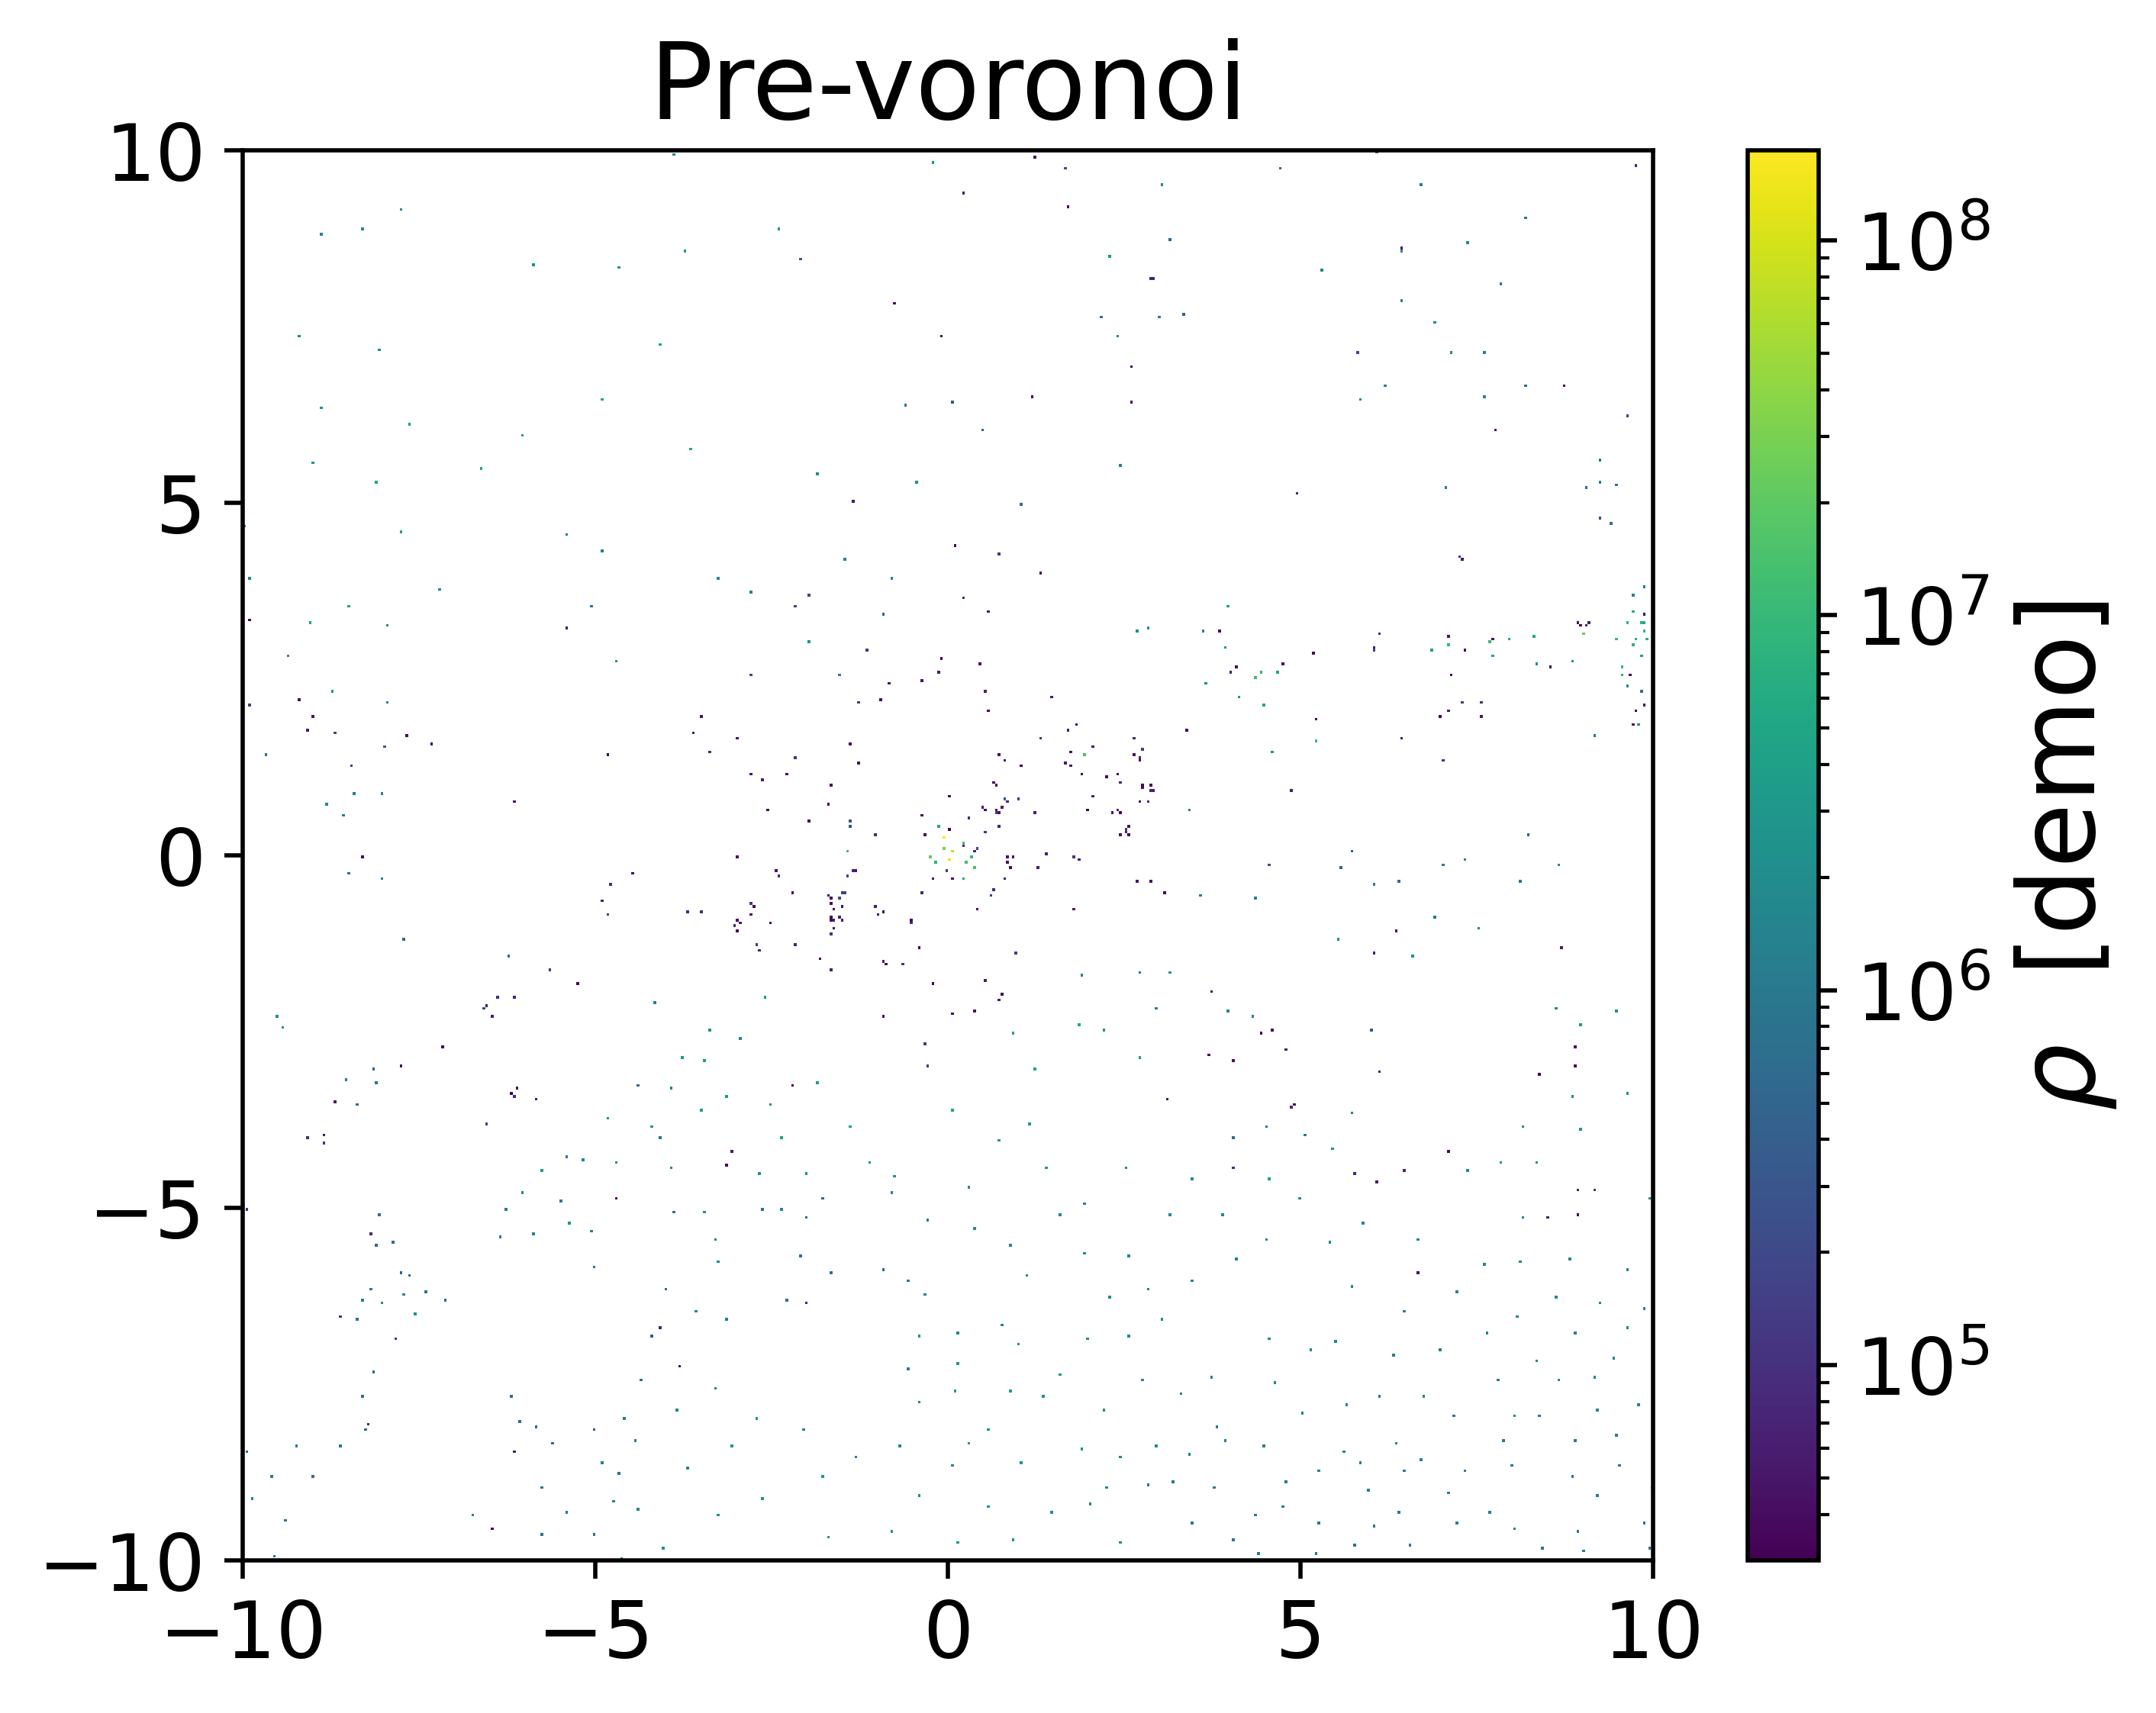

In [35]:
z_slice_min, z_slice_max = [0,0.5]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.sum(ioni_gas["temperatures"][:,:,mask], axis=2).value
# slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
plt.figure(dpi=500)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())


cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$\\rho$  [demo]', fontsize=20)
# plt.xlabel('$x$ [kpc]', size=20)
# plt.ylabel('$y$ [kpc]', size=20)
plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)

plt.title("Pre-voronoi", size=20)

plt.savefig("../visuals/voronoi-demo-pre-12.png", bbox_inches='tight')

plt.show()

In [53]:
np.max(slice_count)

1.2570104536855144e-23

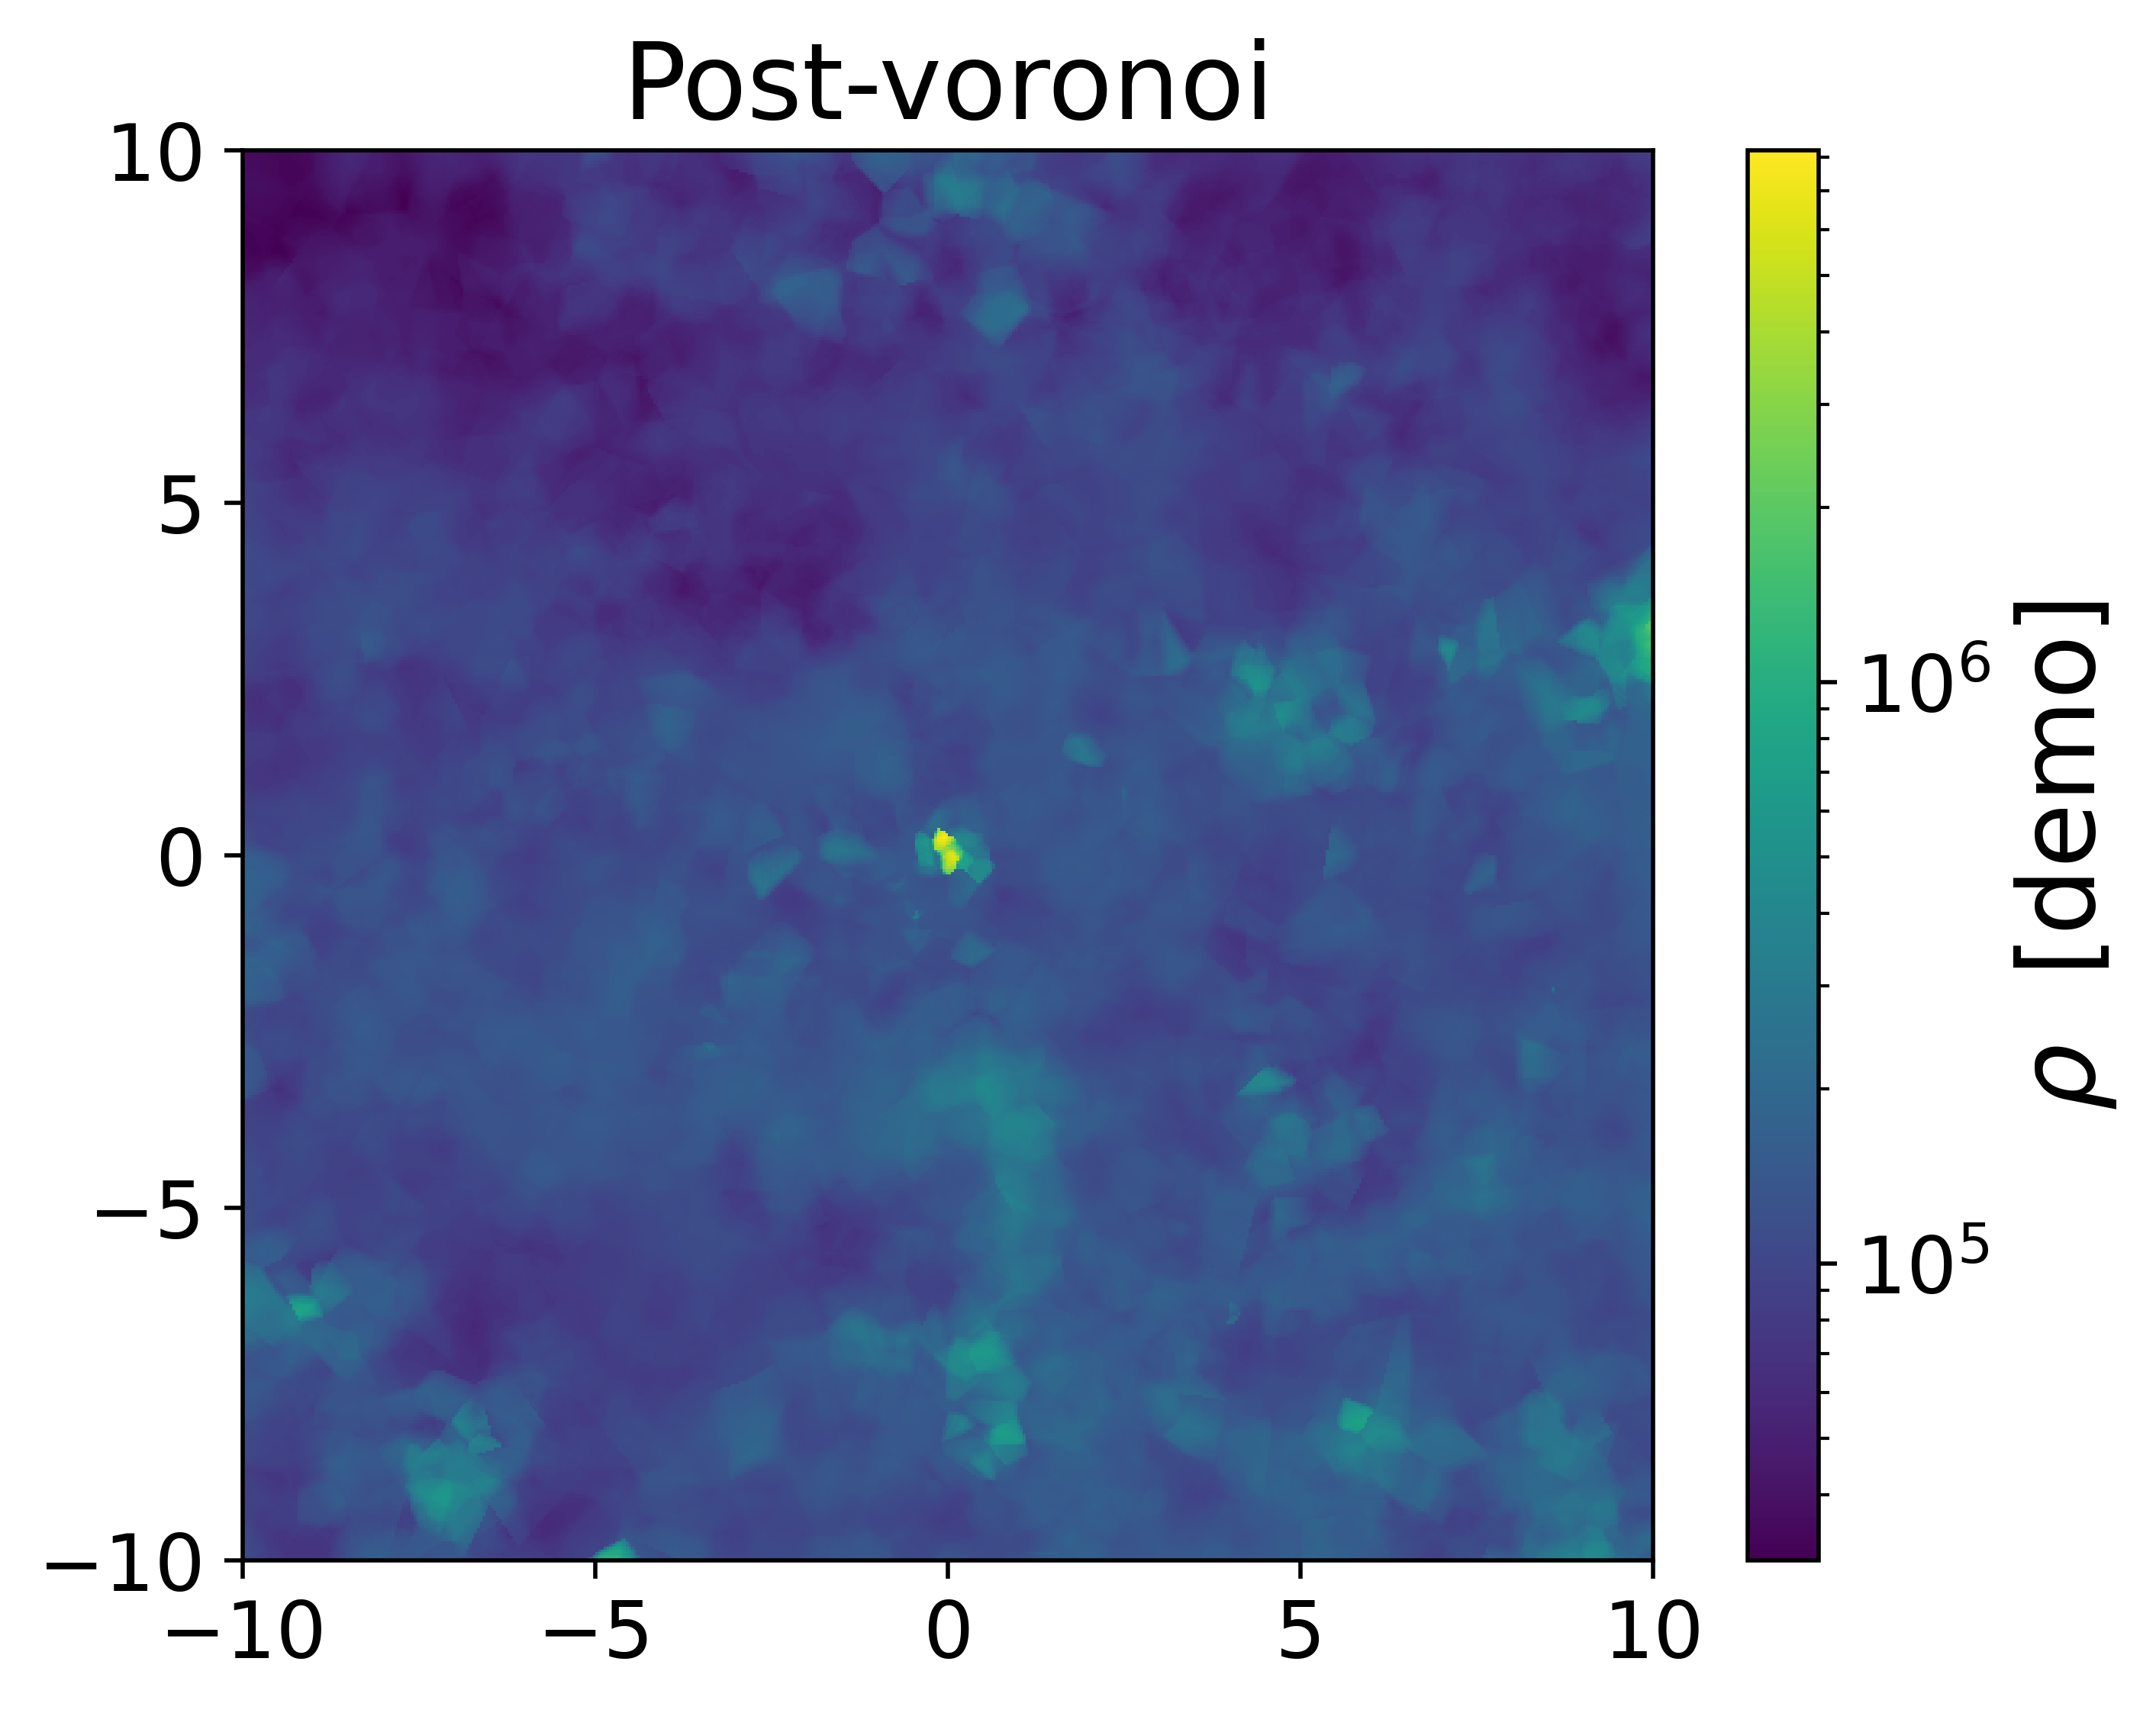

In [34]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.sum(result[:,:,mask], axis=2).value
# slice_count[slice_count==0] = np.min(slice_count[slice_count>0])
plt.figure(dpi=500)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())


cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$\\rho$  [demo]', fontsize=20)
# plt.xlabel('$x$ [kpc]', size=20)
# plt.ylabel('$y$ [kpc]', size=20)
plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)

plt.title("Post-voronoi", size=20)

plt.savefig("../visuals/voronoi-demo-post-11.png", bbox_inches='tight')


plt.show()

In [241]:
index_grid = (grid_c[:,2]>0) & (grid_c[:,2]<0.5)
grid_c[index_grid][:,0]

plt.figure(dpi=500)                                     #   vvvv -> seems inverted, added this as temp. correction
plt.scatter(grid_c[index_grid][:,0], grid_c[index_grid][:,1][::-1], marker='s', s=85, c=ioni_gas["density"][non_empty_ioni_gas][grid_ids][index_grid].value,
           norm = matplotlib.colors.LogNorm())
# plt.colorbar(label='Density')

cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$\\rho$  [demo]', fontsize=20)
# plt.xlabel('$x$ [kpc]', size=20)
# plt.ylabel('$y$ [kpc]', size=20)
plt.xticks(np.array([-10,-5,0,5,10]),fontsize=15)
plt.yticks(np.array([-10,-5,0,5,10]), fontsize=15)

plt.title("Post-voronoi", size=20)
plt.savefig("plots/voronoi-demo-post-9.svg", bbox_inches='tight')
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f809774b9a0> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [41]:
print(np.shape(ioni_gas["density"]))

print(non_empty_ioni_gas)

(512, 512, 512)
[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ...

In [23]:
# np.save("cubes/dark_mat_density.txt", dark_mat["density"].value)
np.savez("cubes/cubes", dark_mat_density = dark_mat["density"].value, 
                        neut_gas_density = neut_gas["density"].value,
                        ioni_gas_density = ioni_gas["density"].value,
                        dv_neut = dv_neut.value,
                        dv_ioni = dv_ioni.value,
                        ioni_gas_temperatures = ioni_gas["temperatures"].value)

In [ ]:
# z_slice_min, z_slice_max = [-0.02,0.02]
# mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
# slice_count = np.sum(ioni_gas["density"][:,:,mask], axis=2)

# plt.figure(dpi=1000)
# plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
# plt.colorbar(label='$\\rho_{DM}$  [kg/m$^3$]')
# plt.xlabel('$x$ [kpc]')
# plt.ylabel('$y$ [kpc]')
# # plt.title("$\rho_{DM}$")
# plt.title("$\\rho_{DM}$ in $z$-slice: ["+str(z_slice_min)+", "+str(z_slice_max)+"] kpc")
# plt.show()

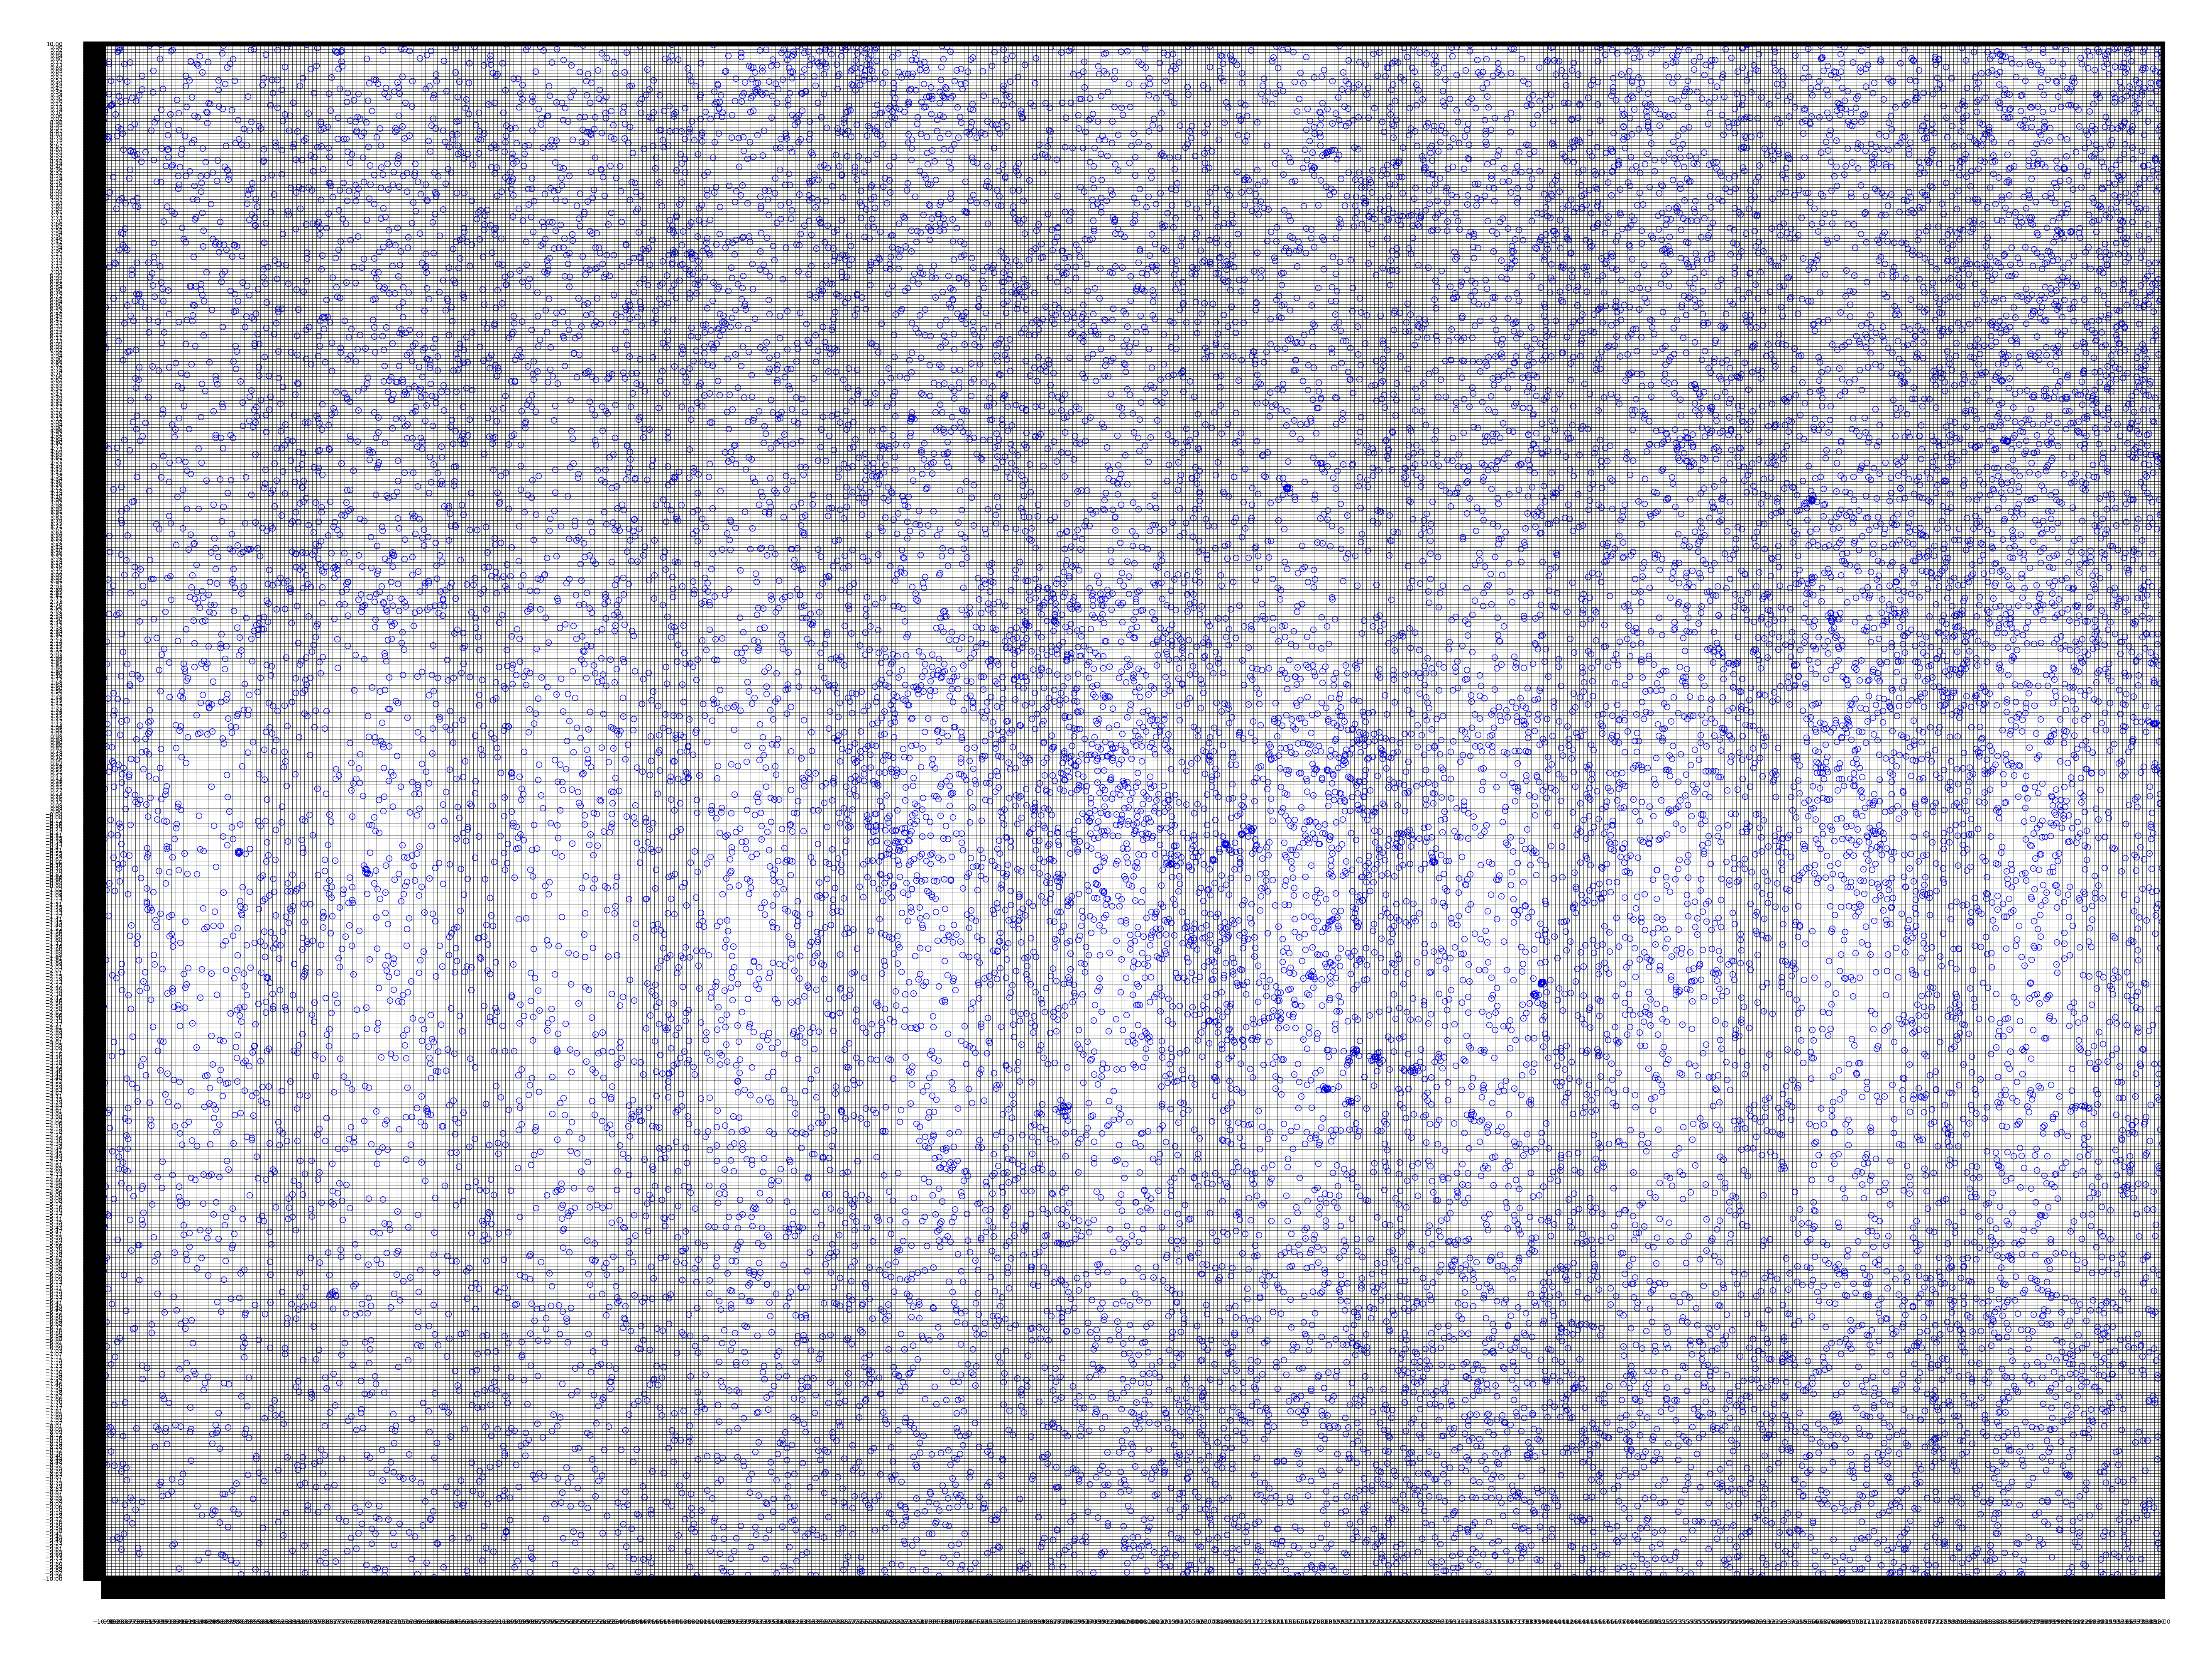

In [10]:
# np.shape(neut_gas["coords"])
plt.figure(dpi=1000)
plt.scatter(ioni_gas["coords"][ioni_gas["within_cube"]][:,0], ioni_gas["coords"][ioni_gas["within_cube"]][:,1], s=0.01, color="blue")
plt.grid(visible=True, linestyle='-', linewidth=0.05, color="black")
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.xticks(bins, size=0, labels=None)
plt.yticks(bins, size=0, labels=None)
plt.show()

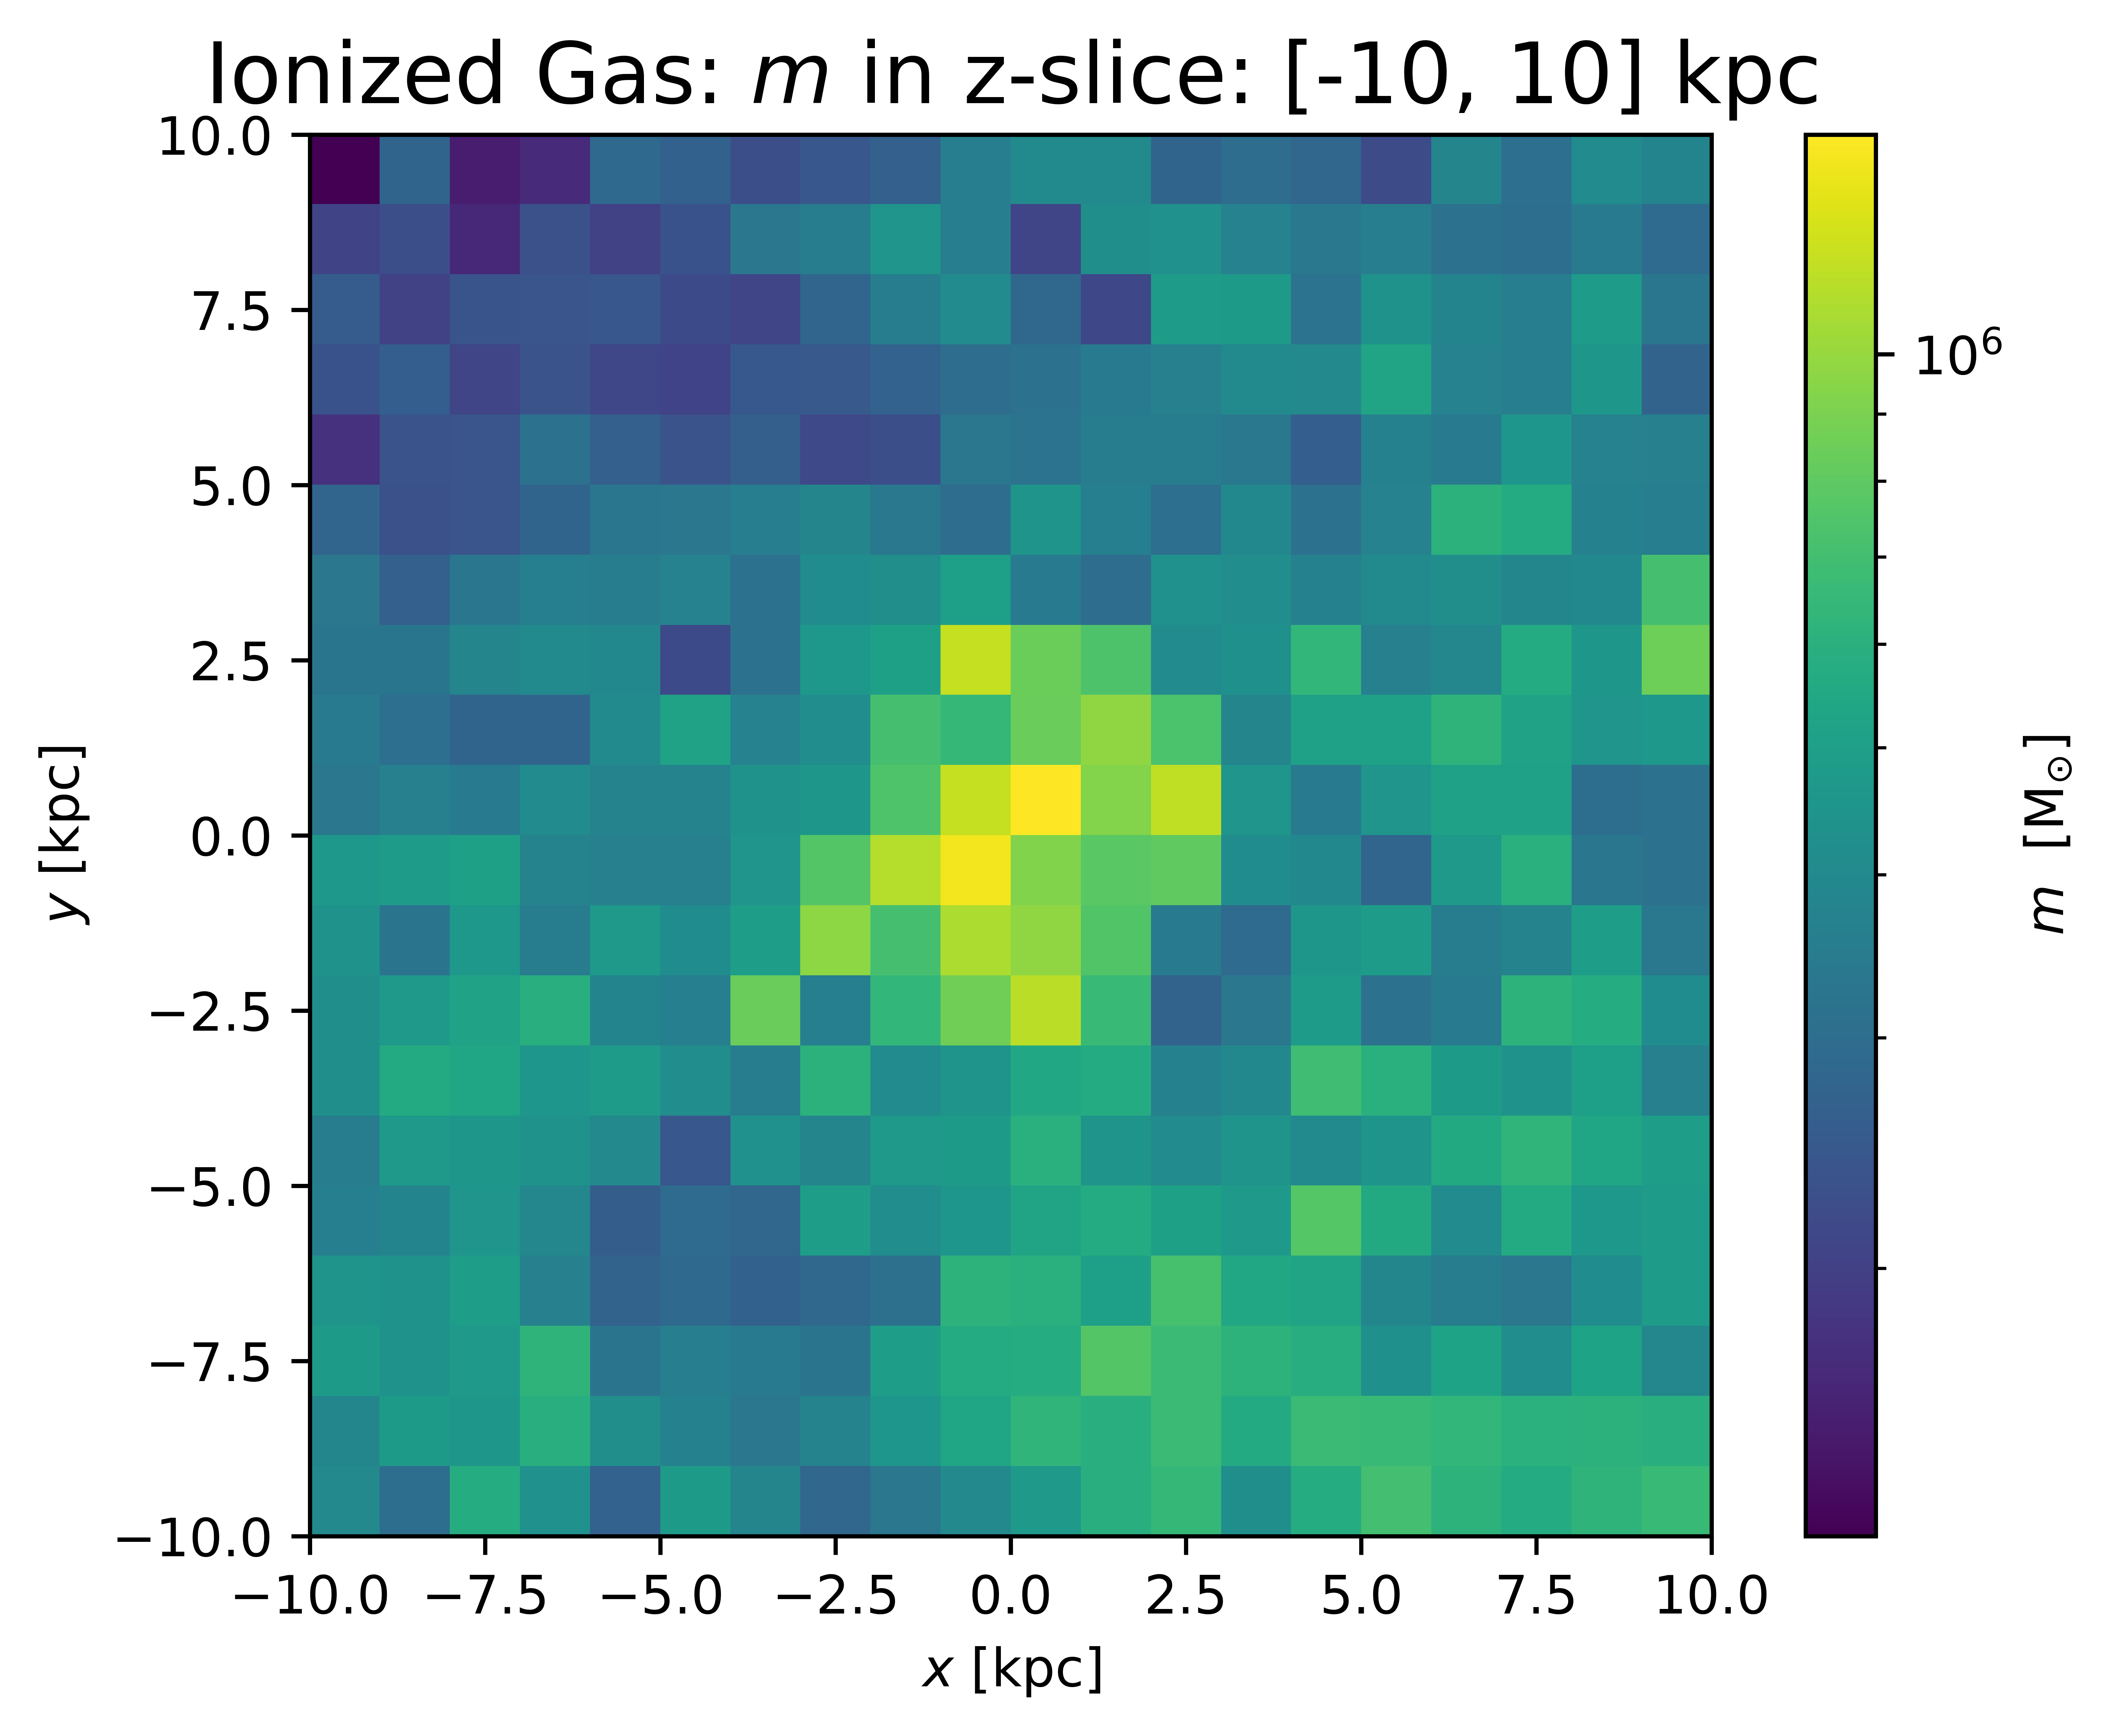

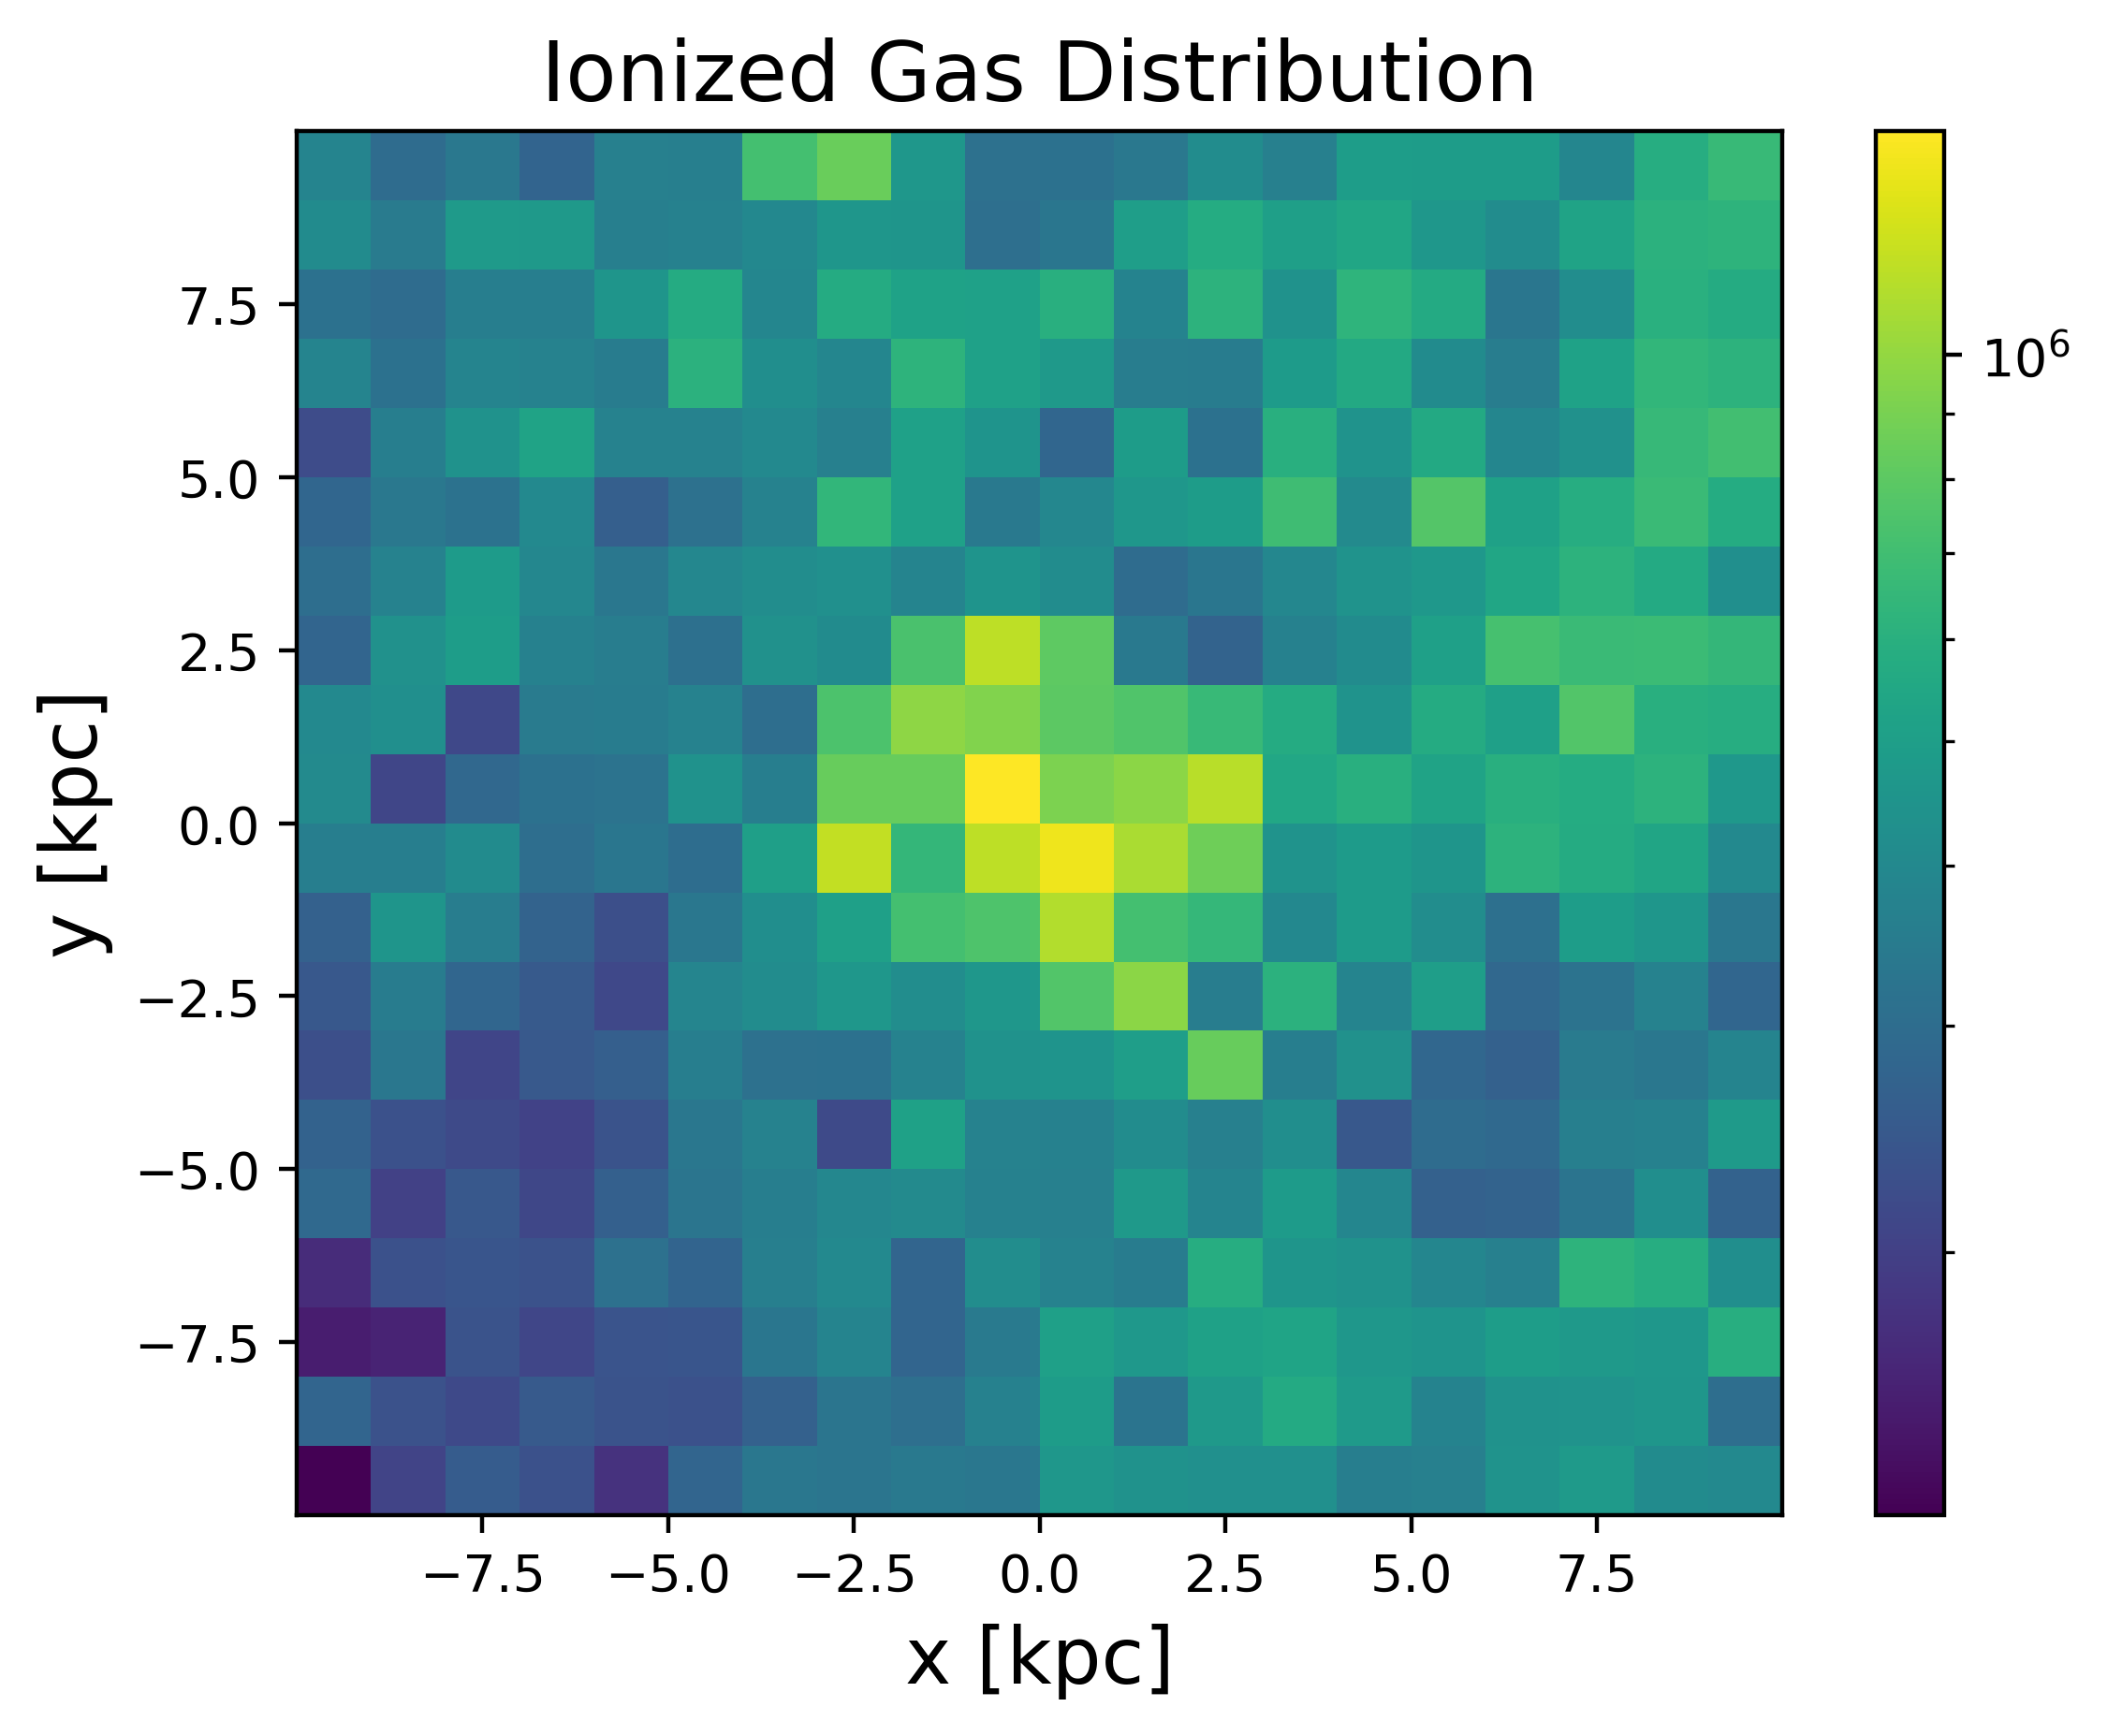

0.0


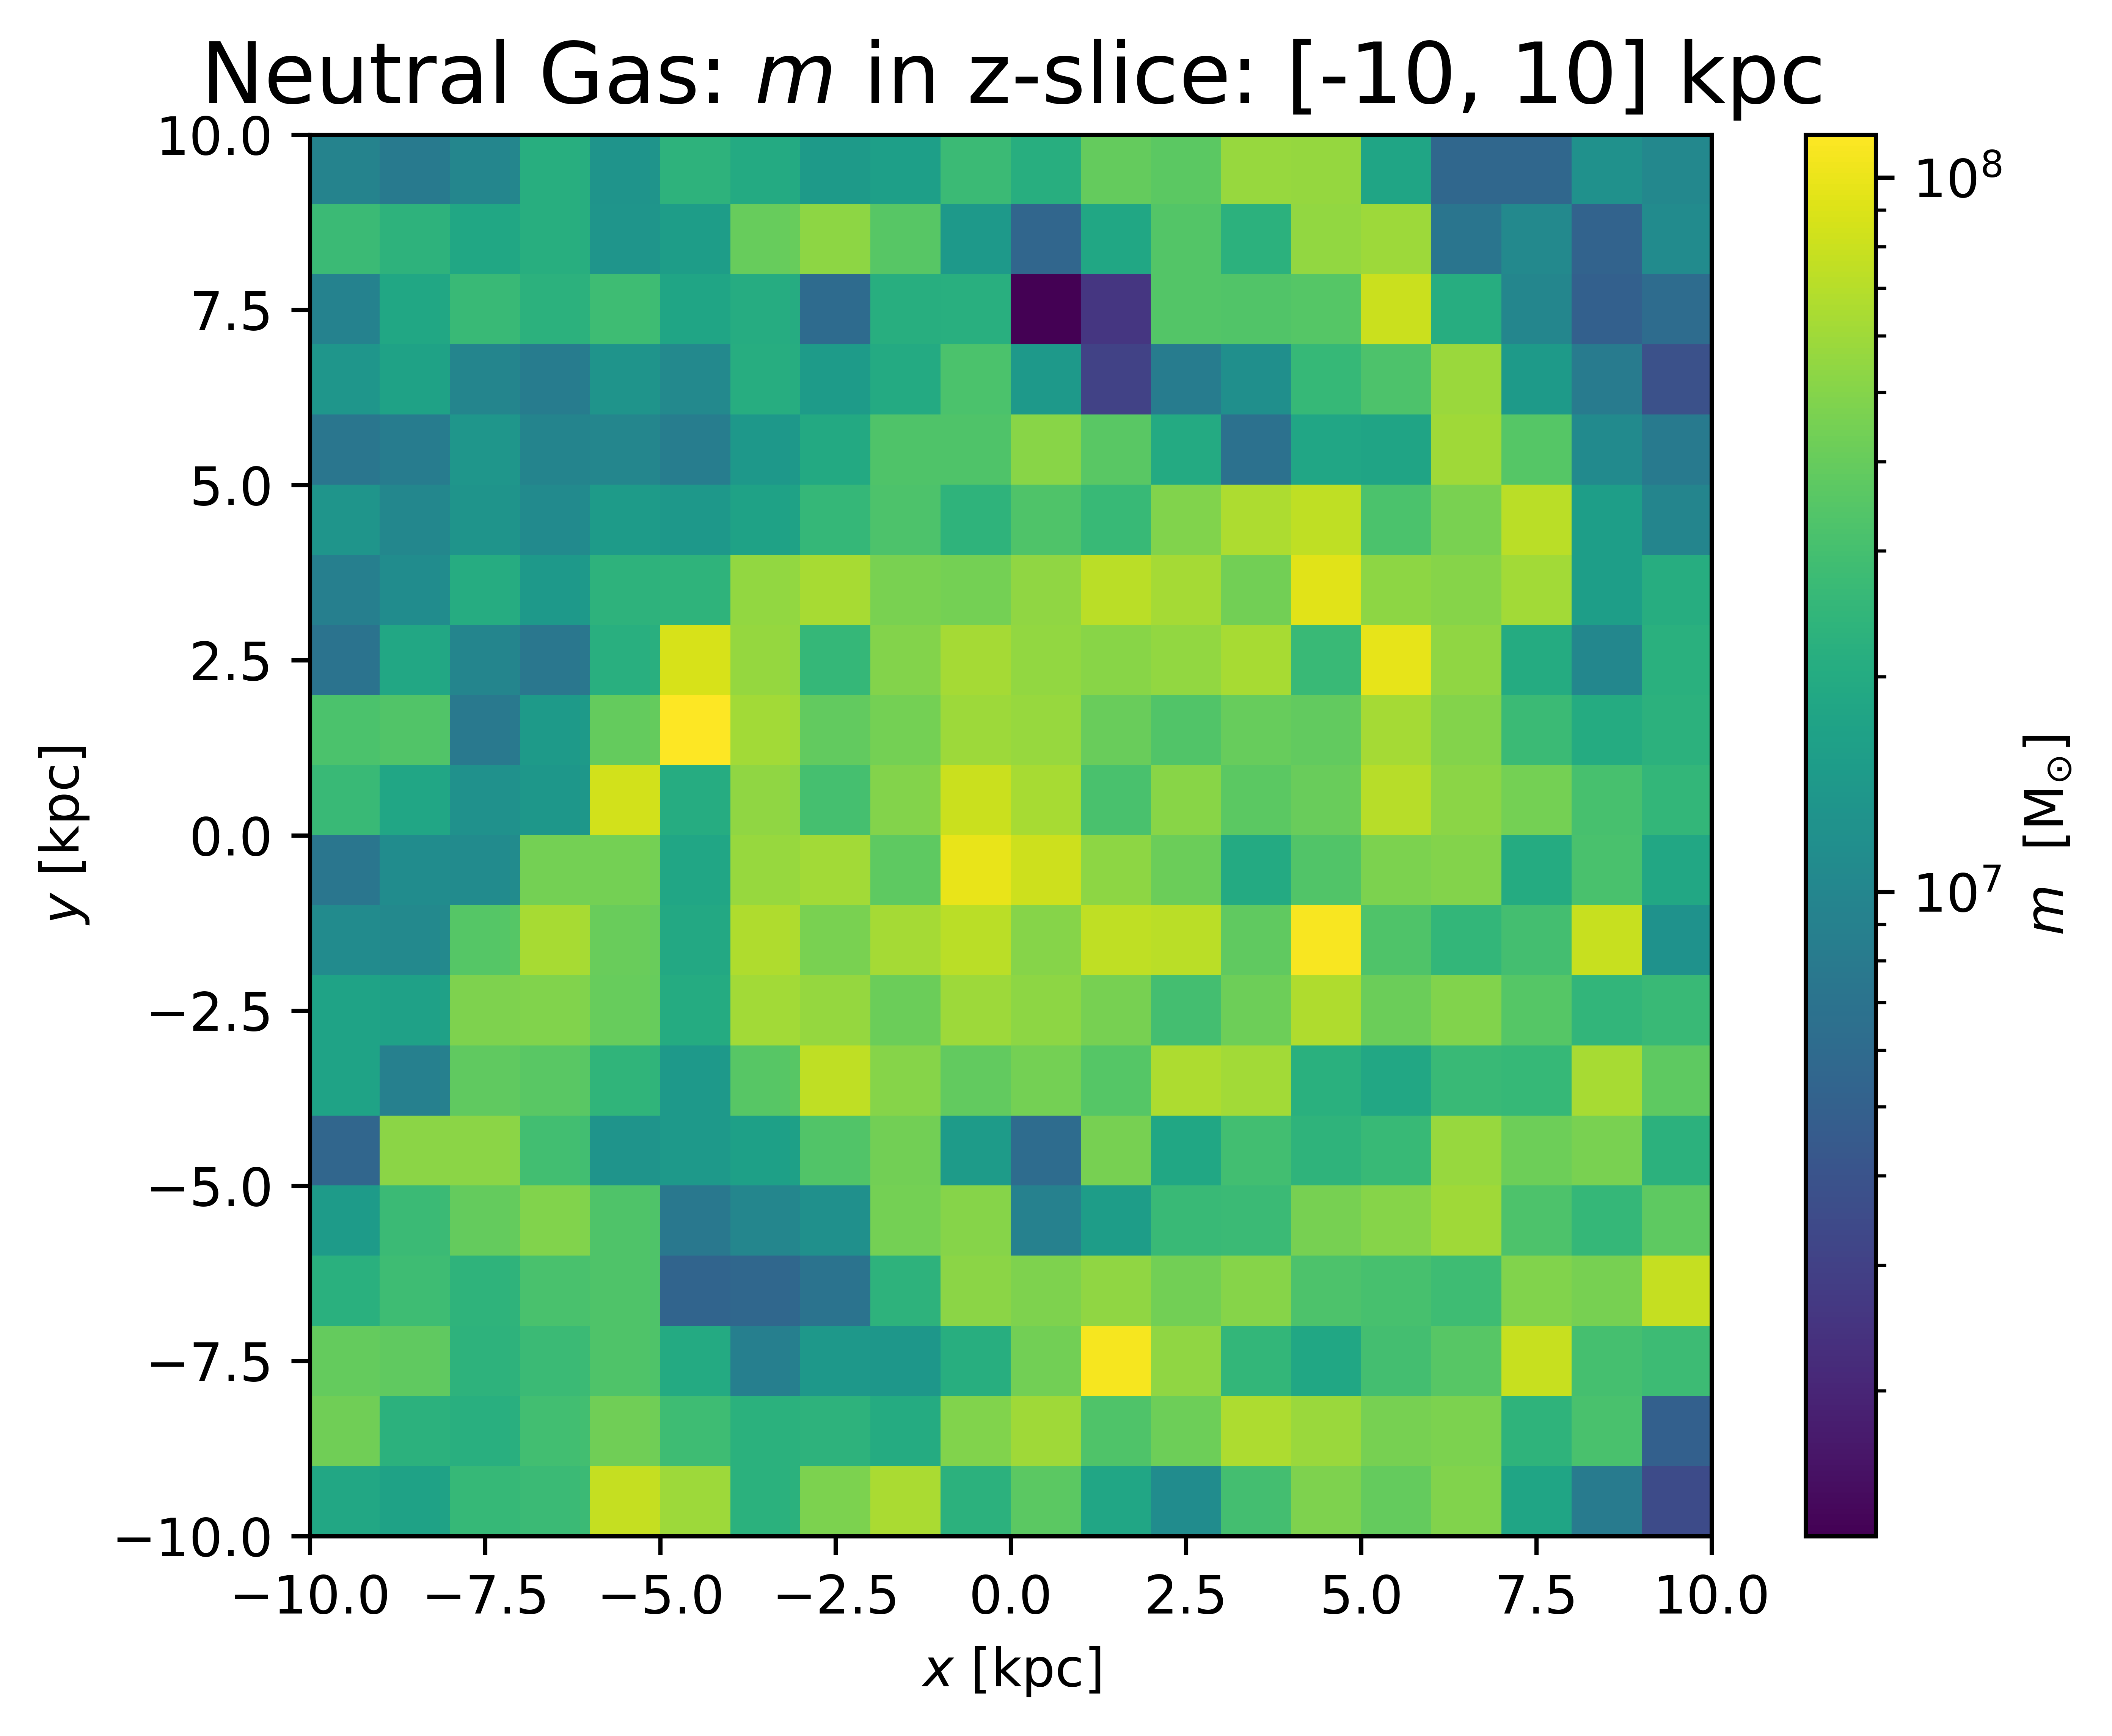

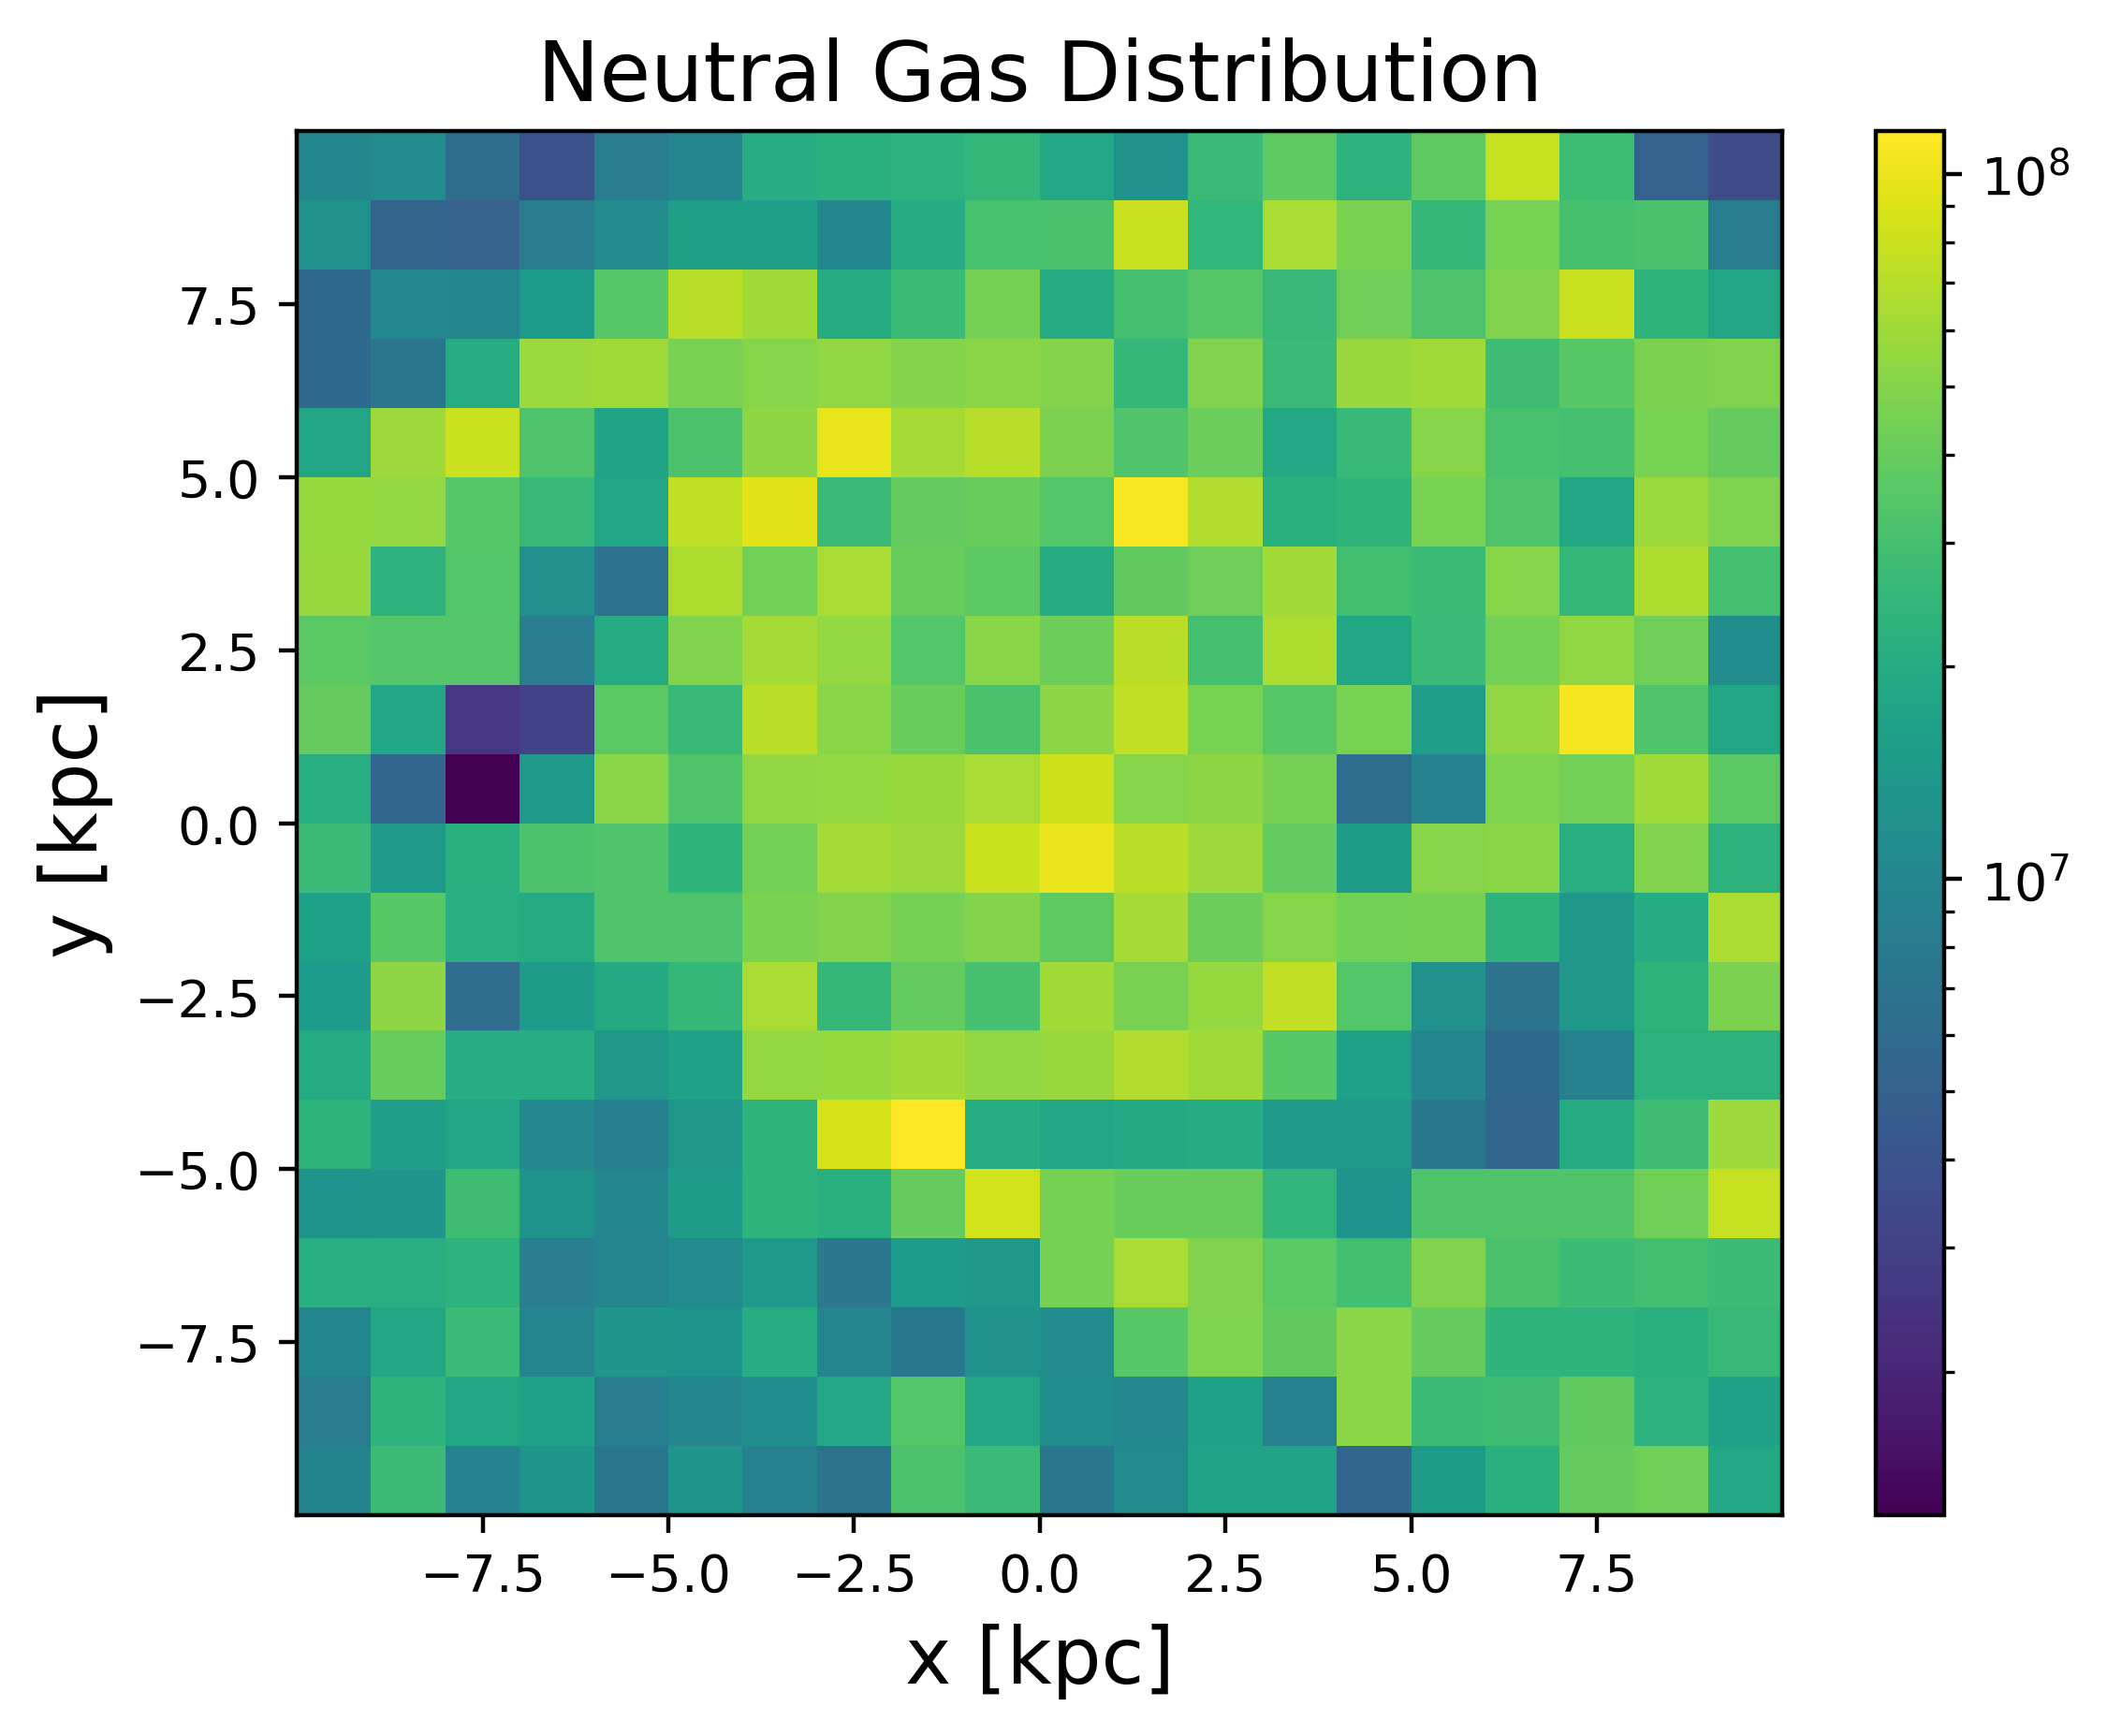

0.0


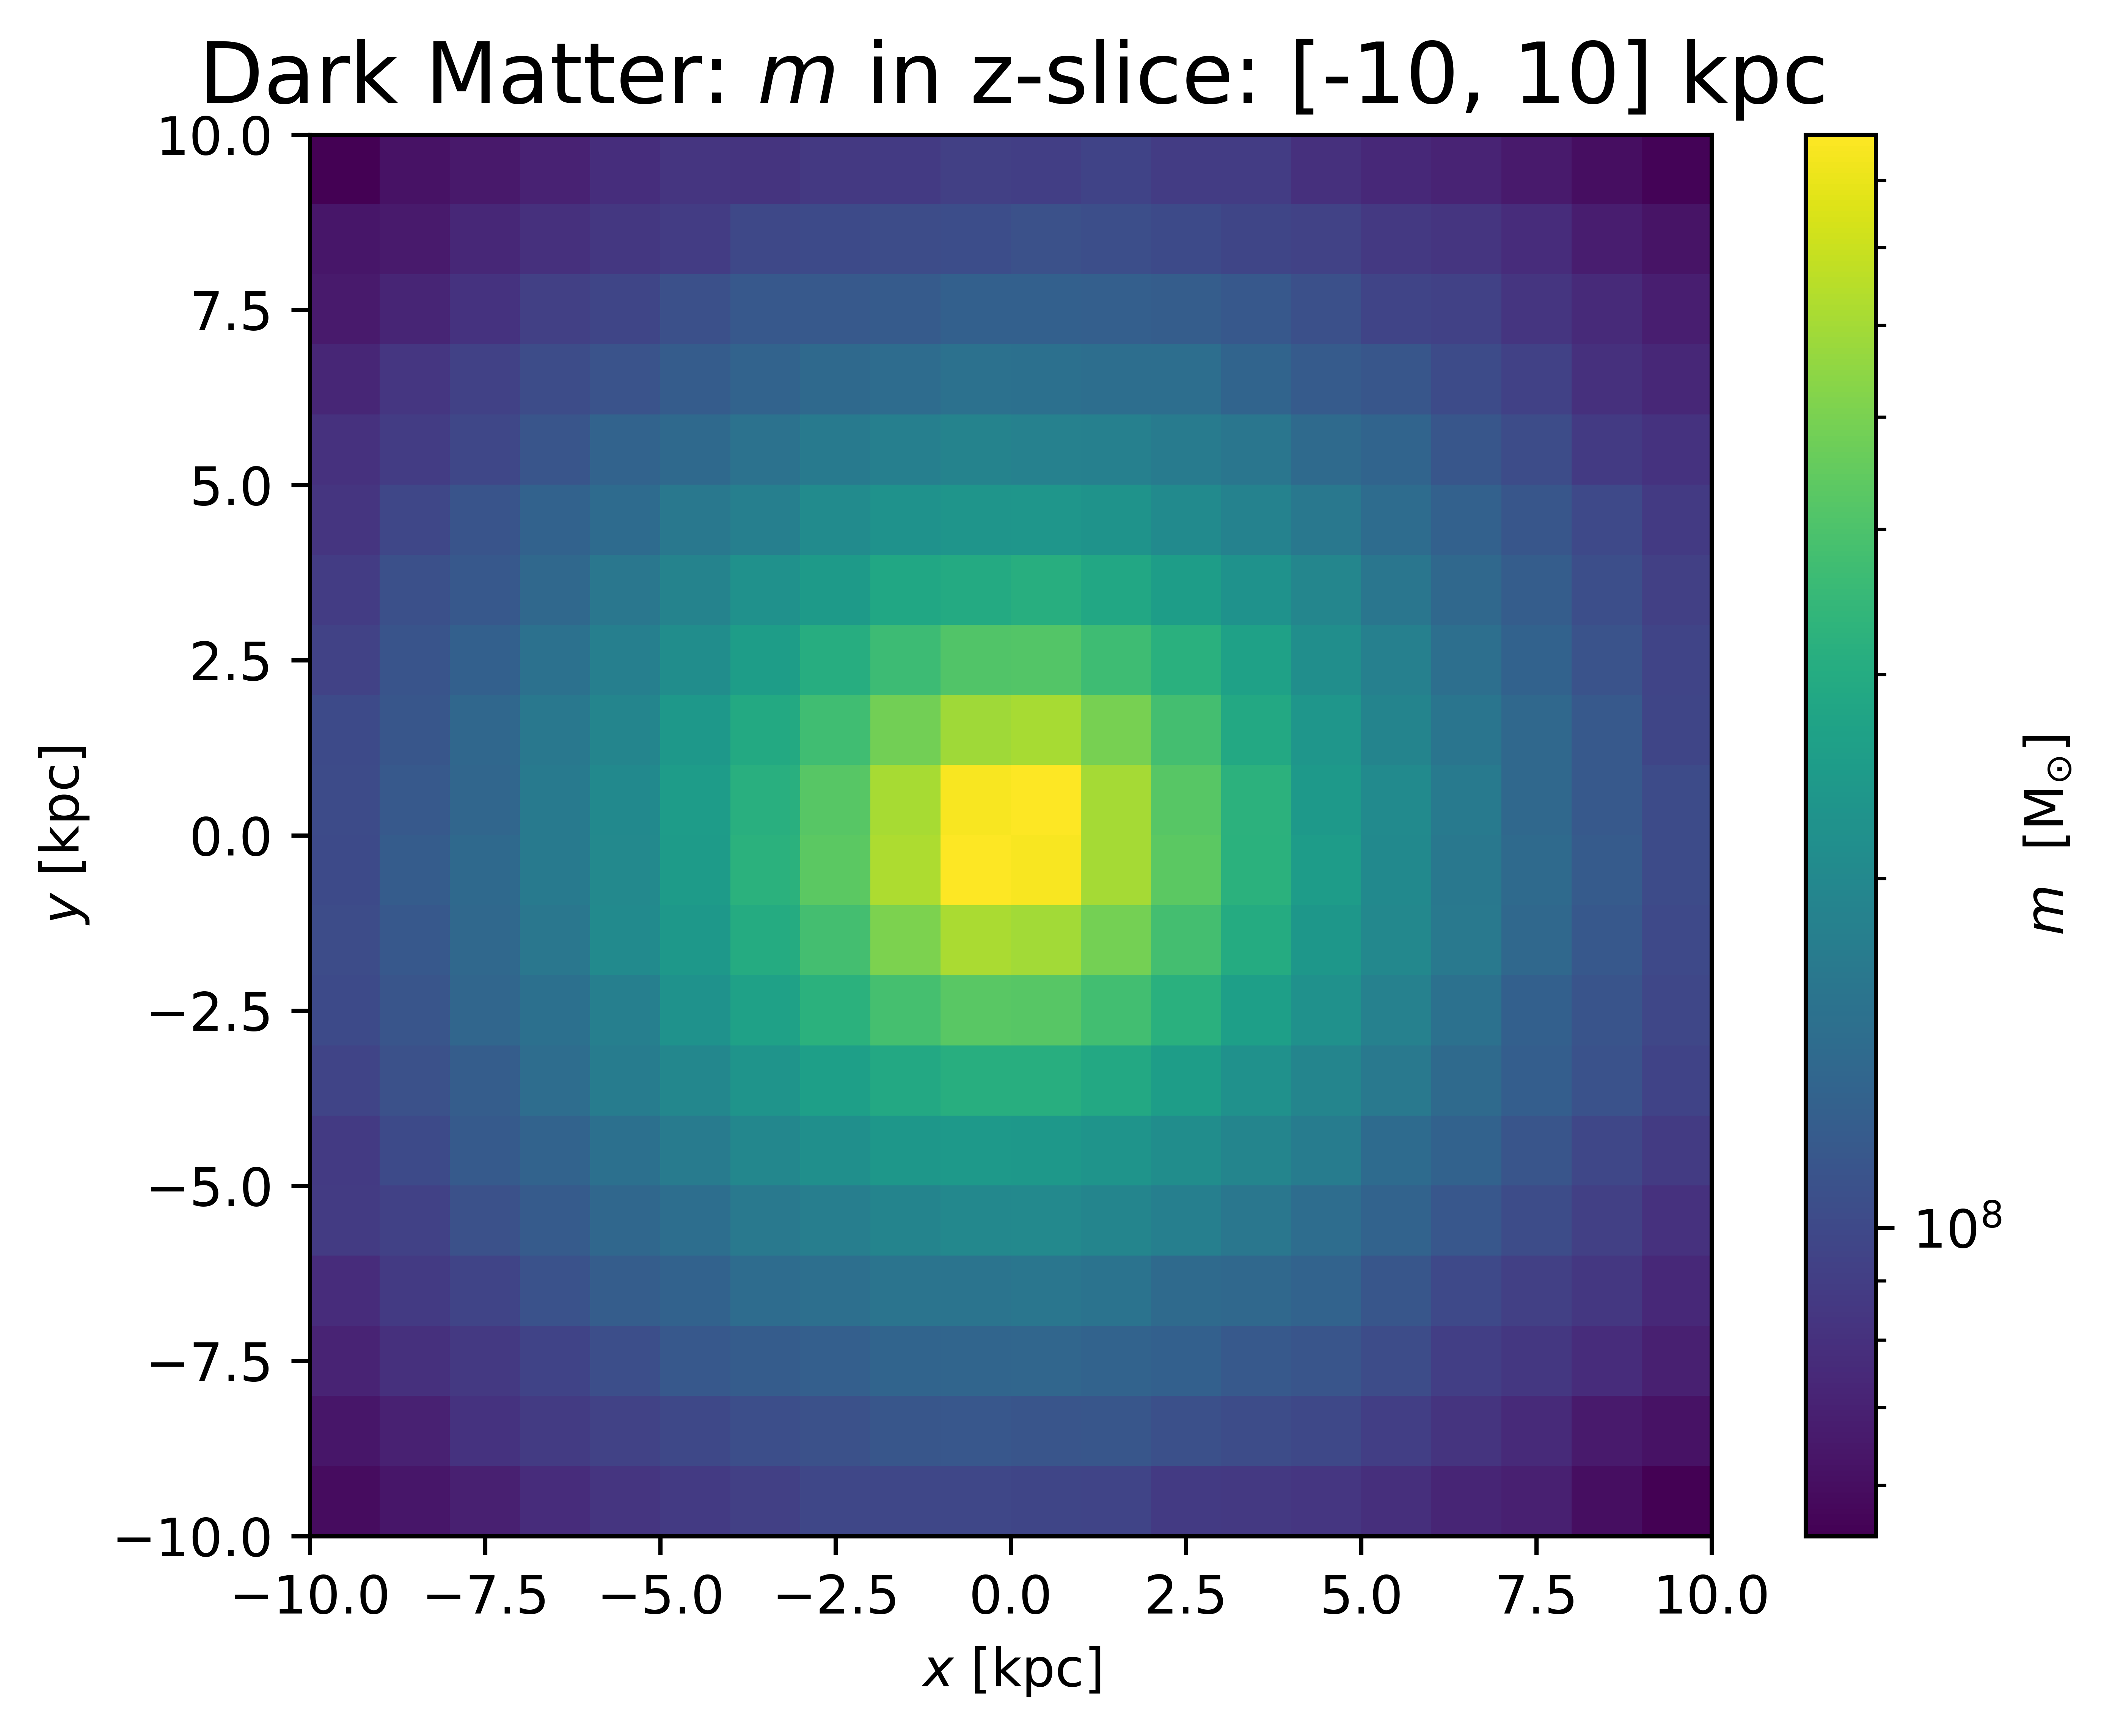

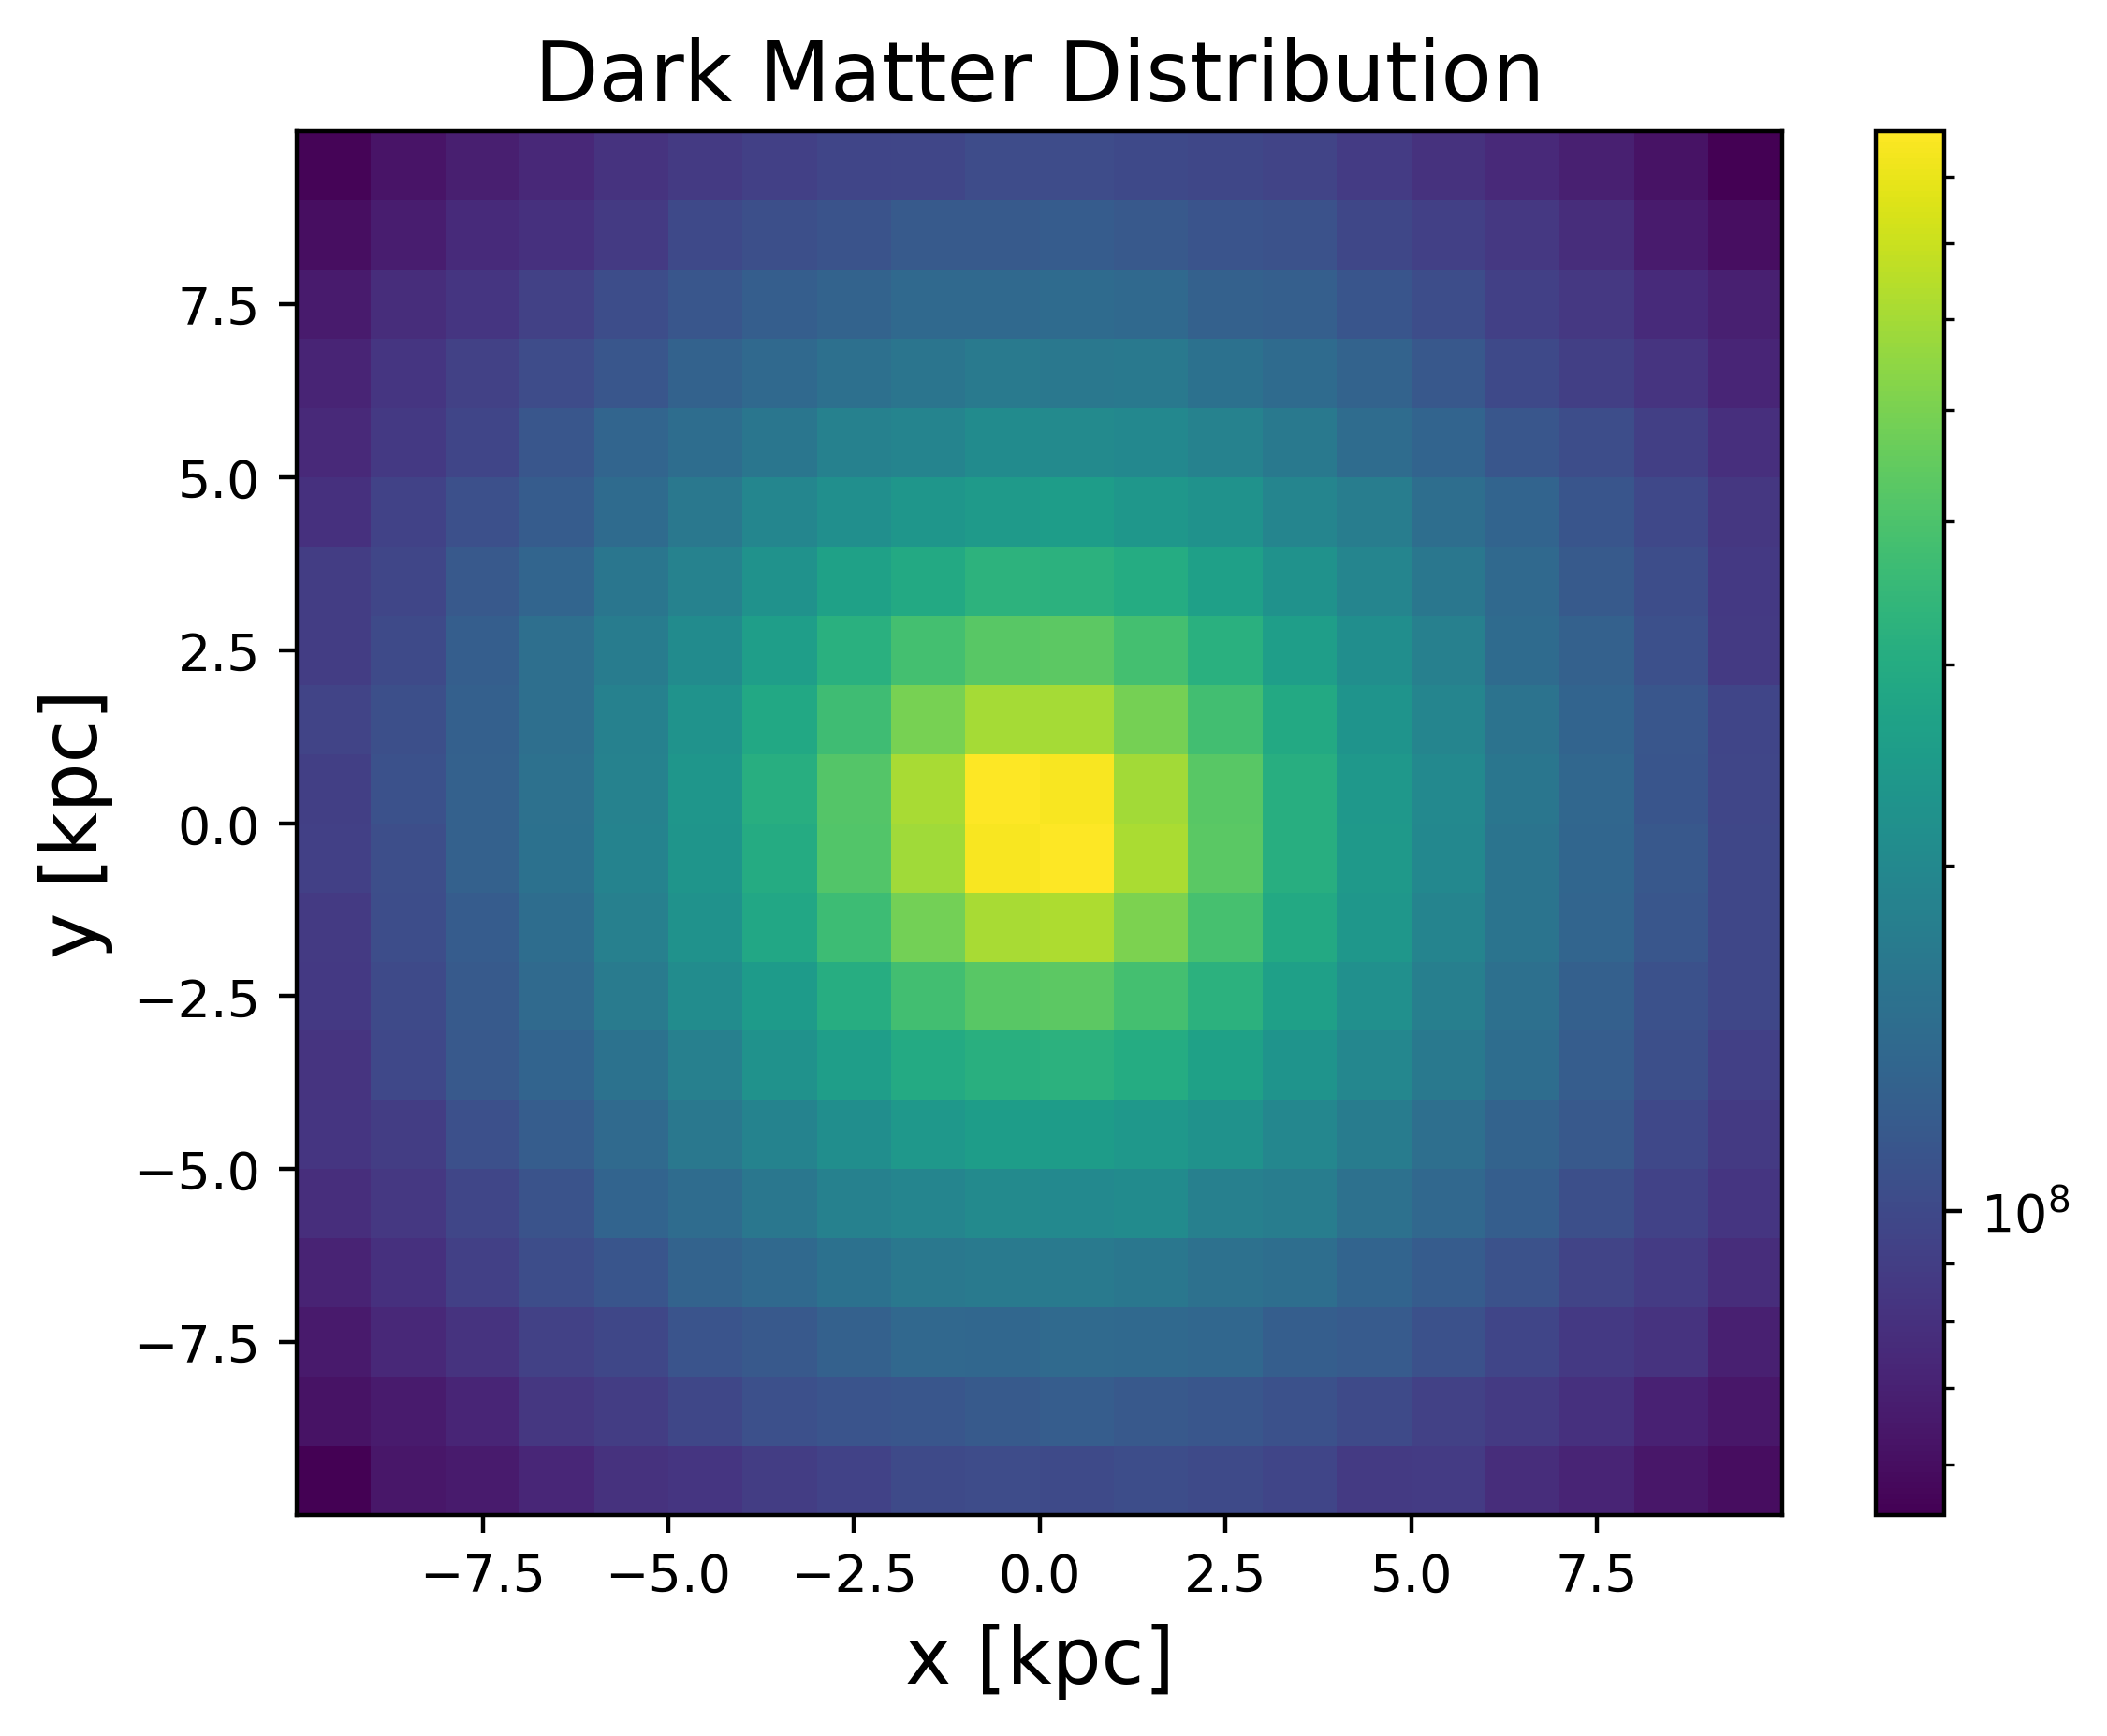

0.0


In [72]:
perform_sanity_check = True

if perform_sanity_check:
    z_slice_min, z_slice_max = [-10,10]
    mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)

    for dict in [ioni_gas, neut_gas, dark_mat]:
    
        slice_count = np.sum(dict["mass_count"][:,:,mask], axis=2)

        plt.figure(dpi=1000)
        plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
        plt.colorbar(label='$m$  [M$_{\odot}$]')
        plt.xlabel('$x$ [kpc]')
        plt.ylabel('$y$ [kpc]')
        plt.title(dict["name"]+": $m$ in z-slice: ["+str(z_slice_min)+", "+str(z_slice_max)+"] kpc", size=16)
        plt.savefig("plots/cube - "+dict["name"]+" mass.png", bbox_inches='tight')
        # plt.savefig("plots/cube - "+dict["name"]+" mass.svg", bbox_inches='tight')
        
        plt.show()

        ##############################################################################

        fig = plt.figure(dpi=400)
        ax = plt.gca()
        histo = ax.hist2d(dict["coords"][dict["within_cube"]][:,0],
                          dict["coords"][dict["within_cube"]][:,1],
                          bins = voxel_resolution,
                          norm = matplotlib.colors.LogNorm(), 
                          weights = dict["masses"])
        fig.colorbar(histo[3], ax=ax)
        ax.set_xlabel("x [kpc]",size=15)
        ax.set_ylabel("y [kpc]",size=15)
        ax.set_title(dict["name"]+" Distribution", size=16)

        plt.show()

        print(np.sum(slice_count - histo[0]))



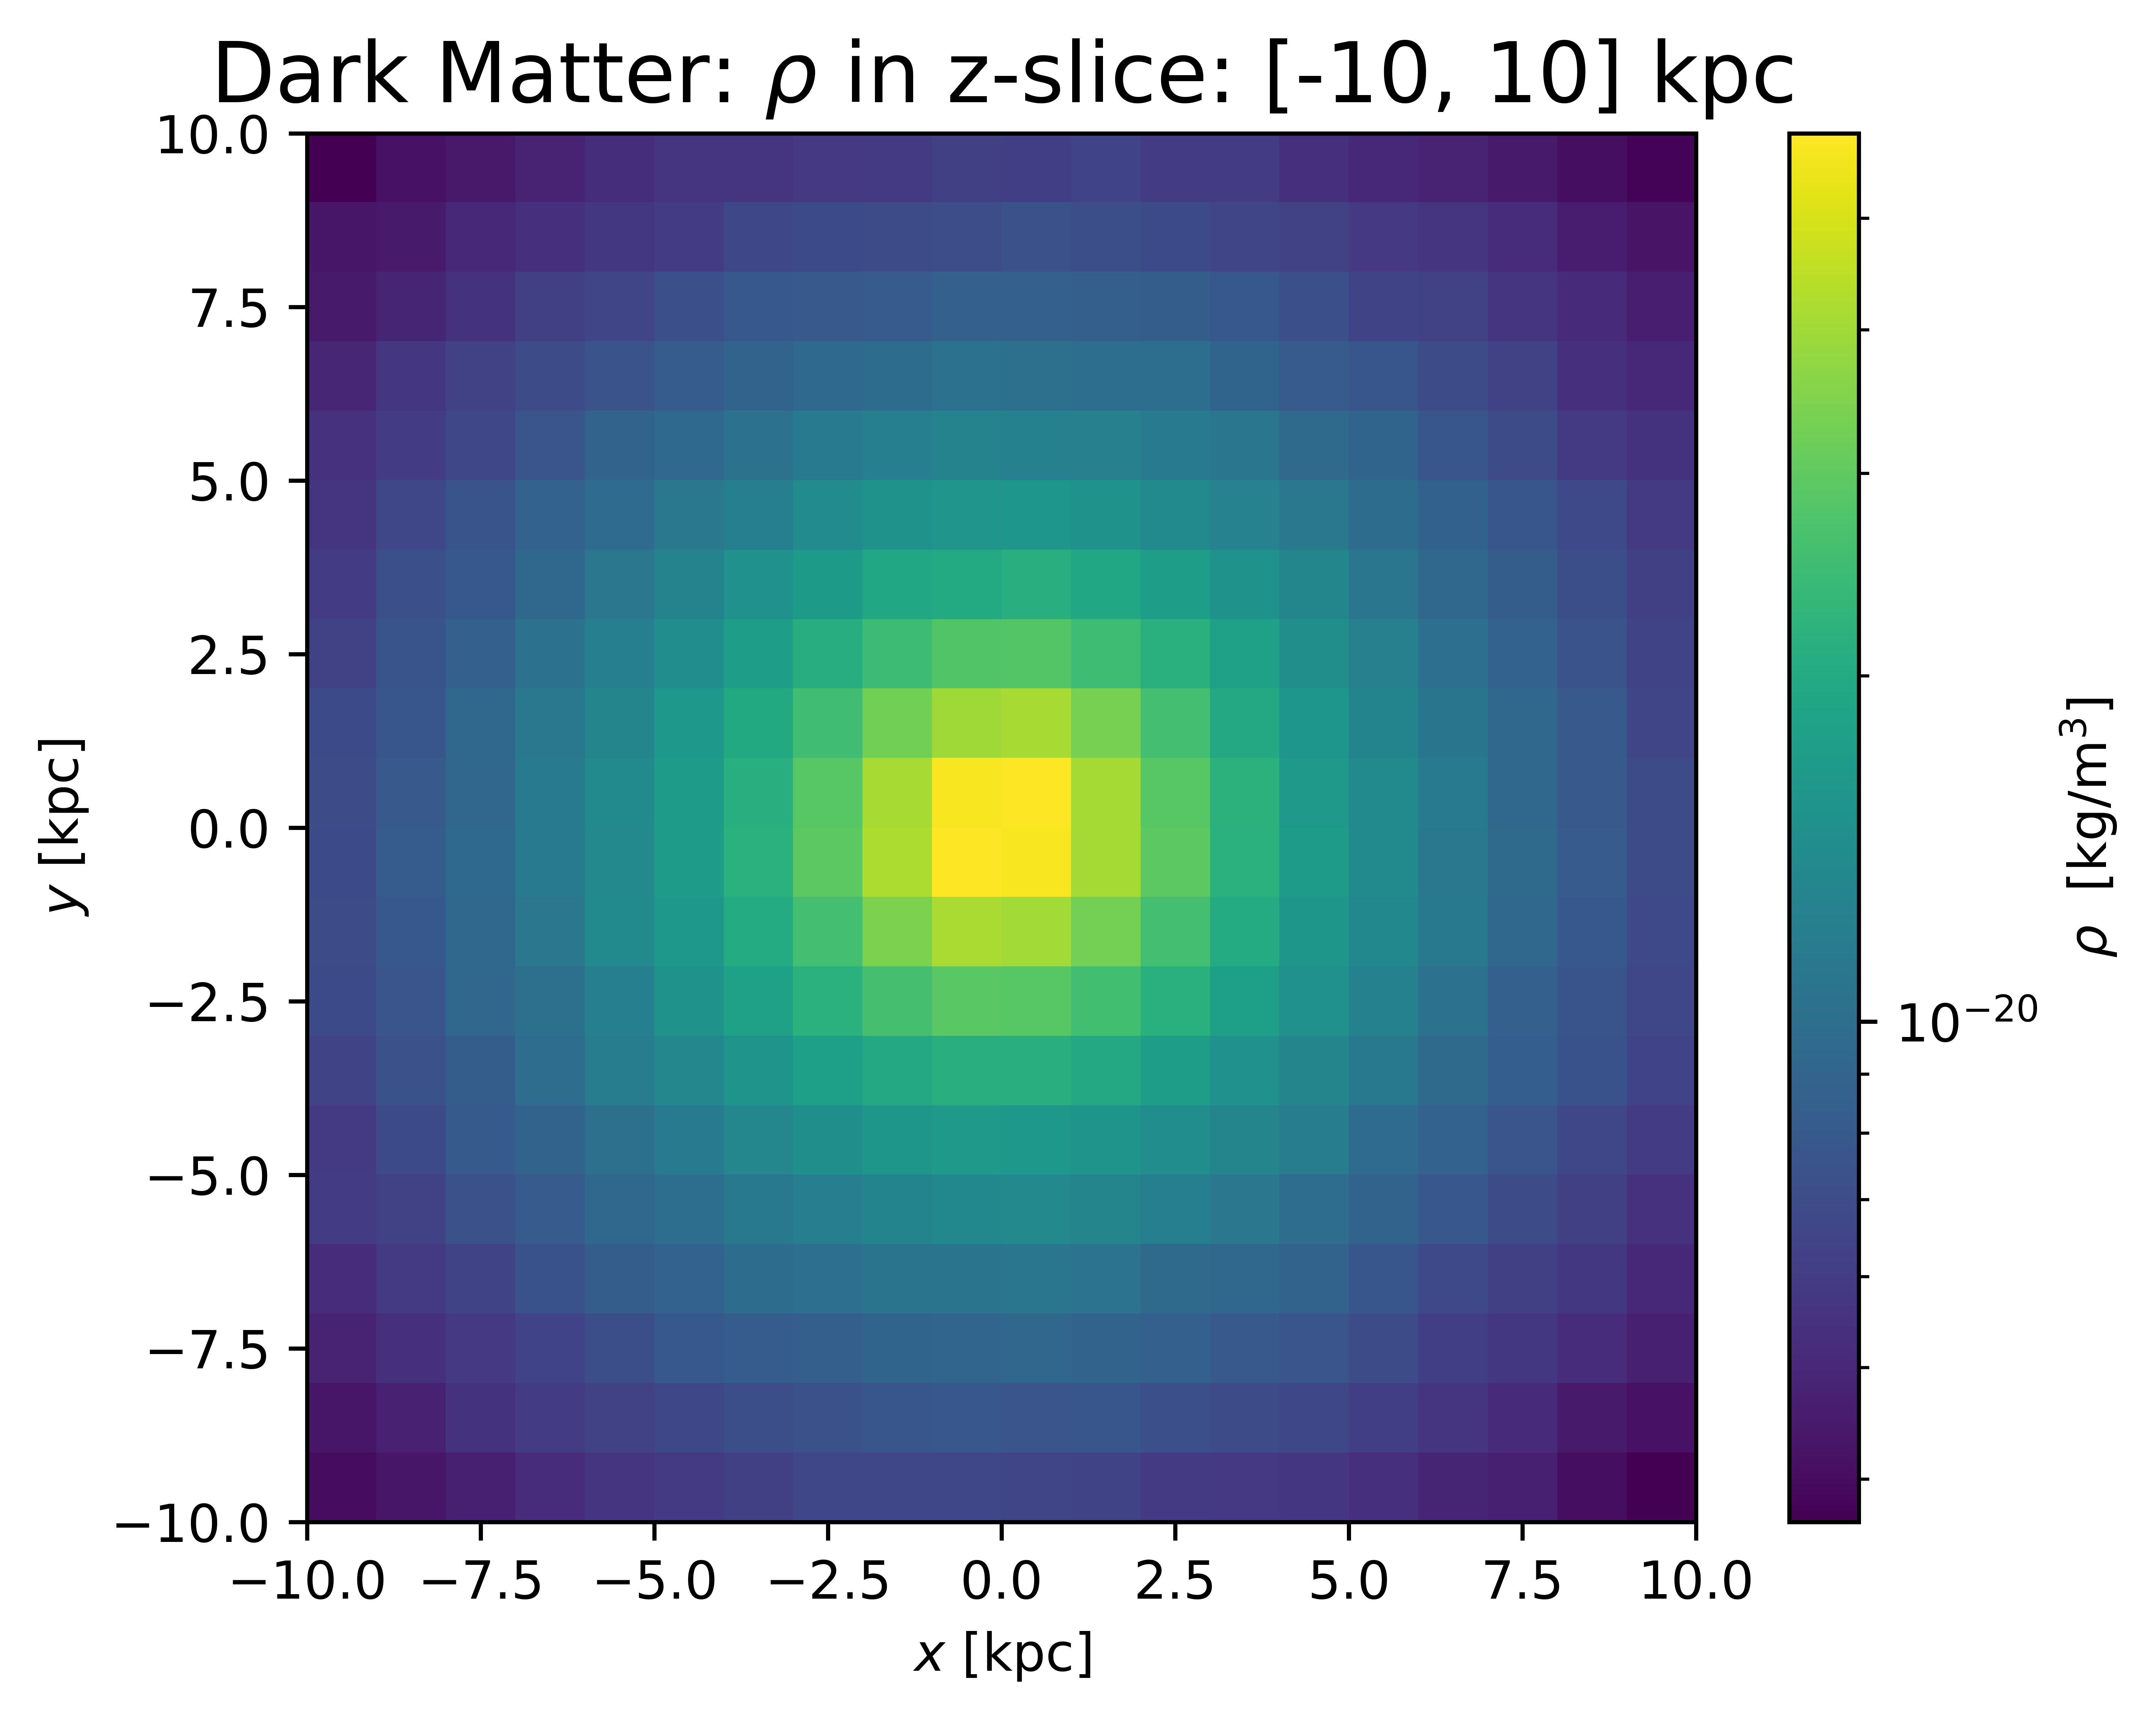

In [73]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.sum(dark_mat["density"][:,:,mask], axis=2).value

plt.figure(dpi=1000)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho$  [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
# plt.title("$\rho_{DM}$")
plt.title(dark_mat["name"]+": $\\rho$ in z-slice: ["+str(z_slice_min)+", "+str(z_slice_max)+"] kpc", size=16)
plt.savefig("plots/cube - "+dark_mat["name"]+" density.png", bbox_inches='tight')
plt.show()

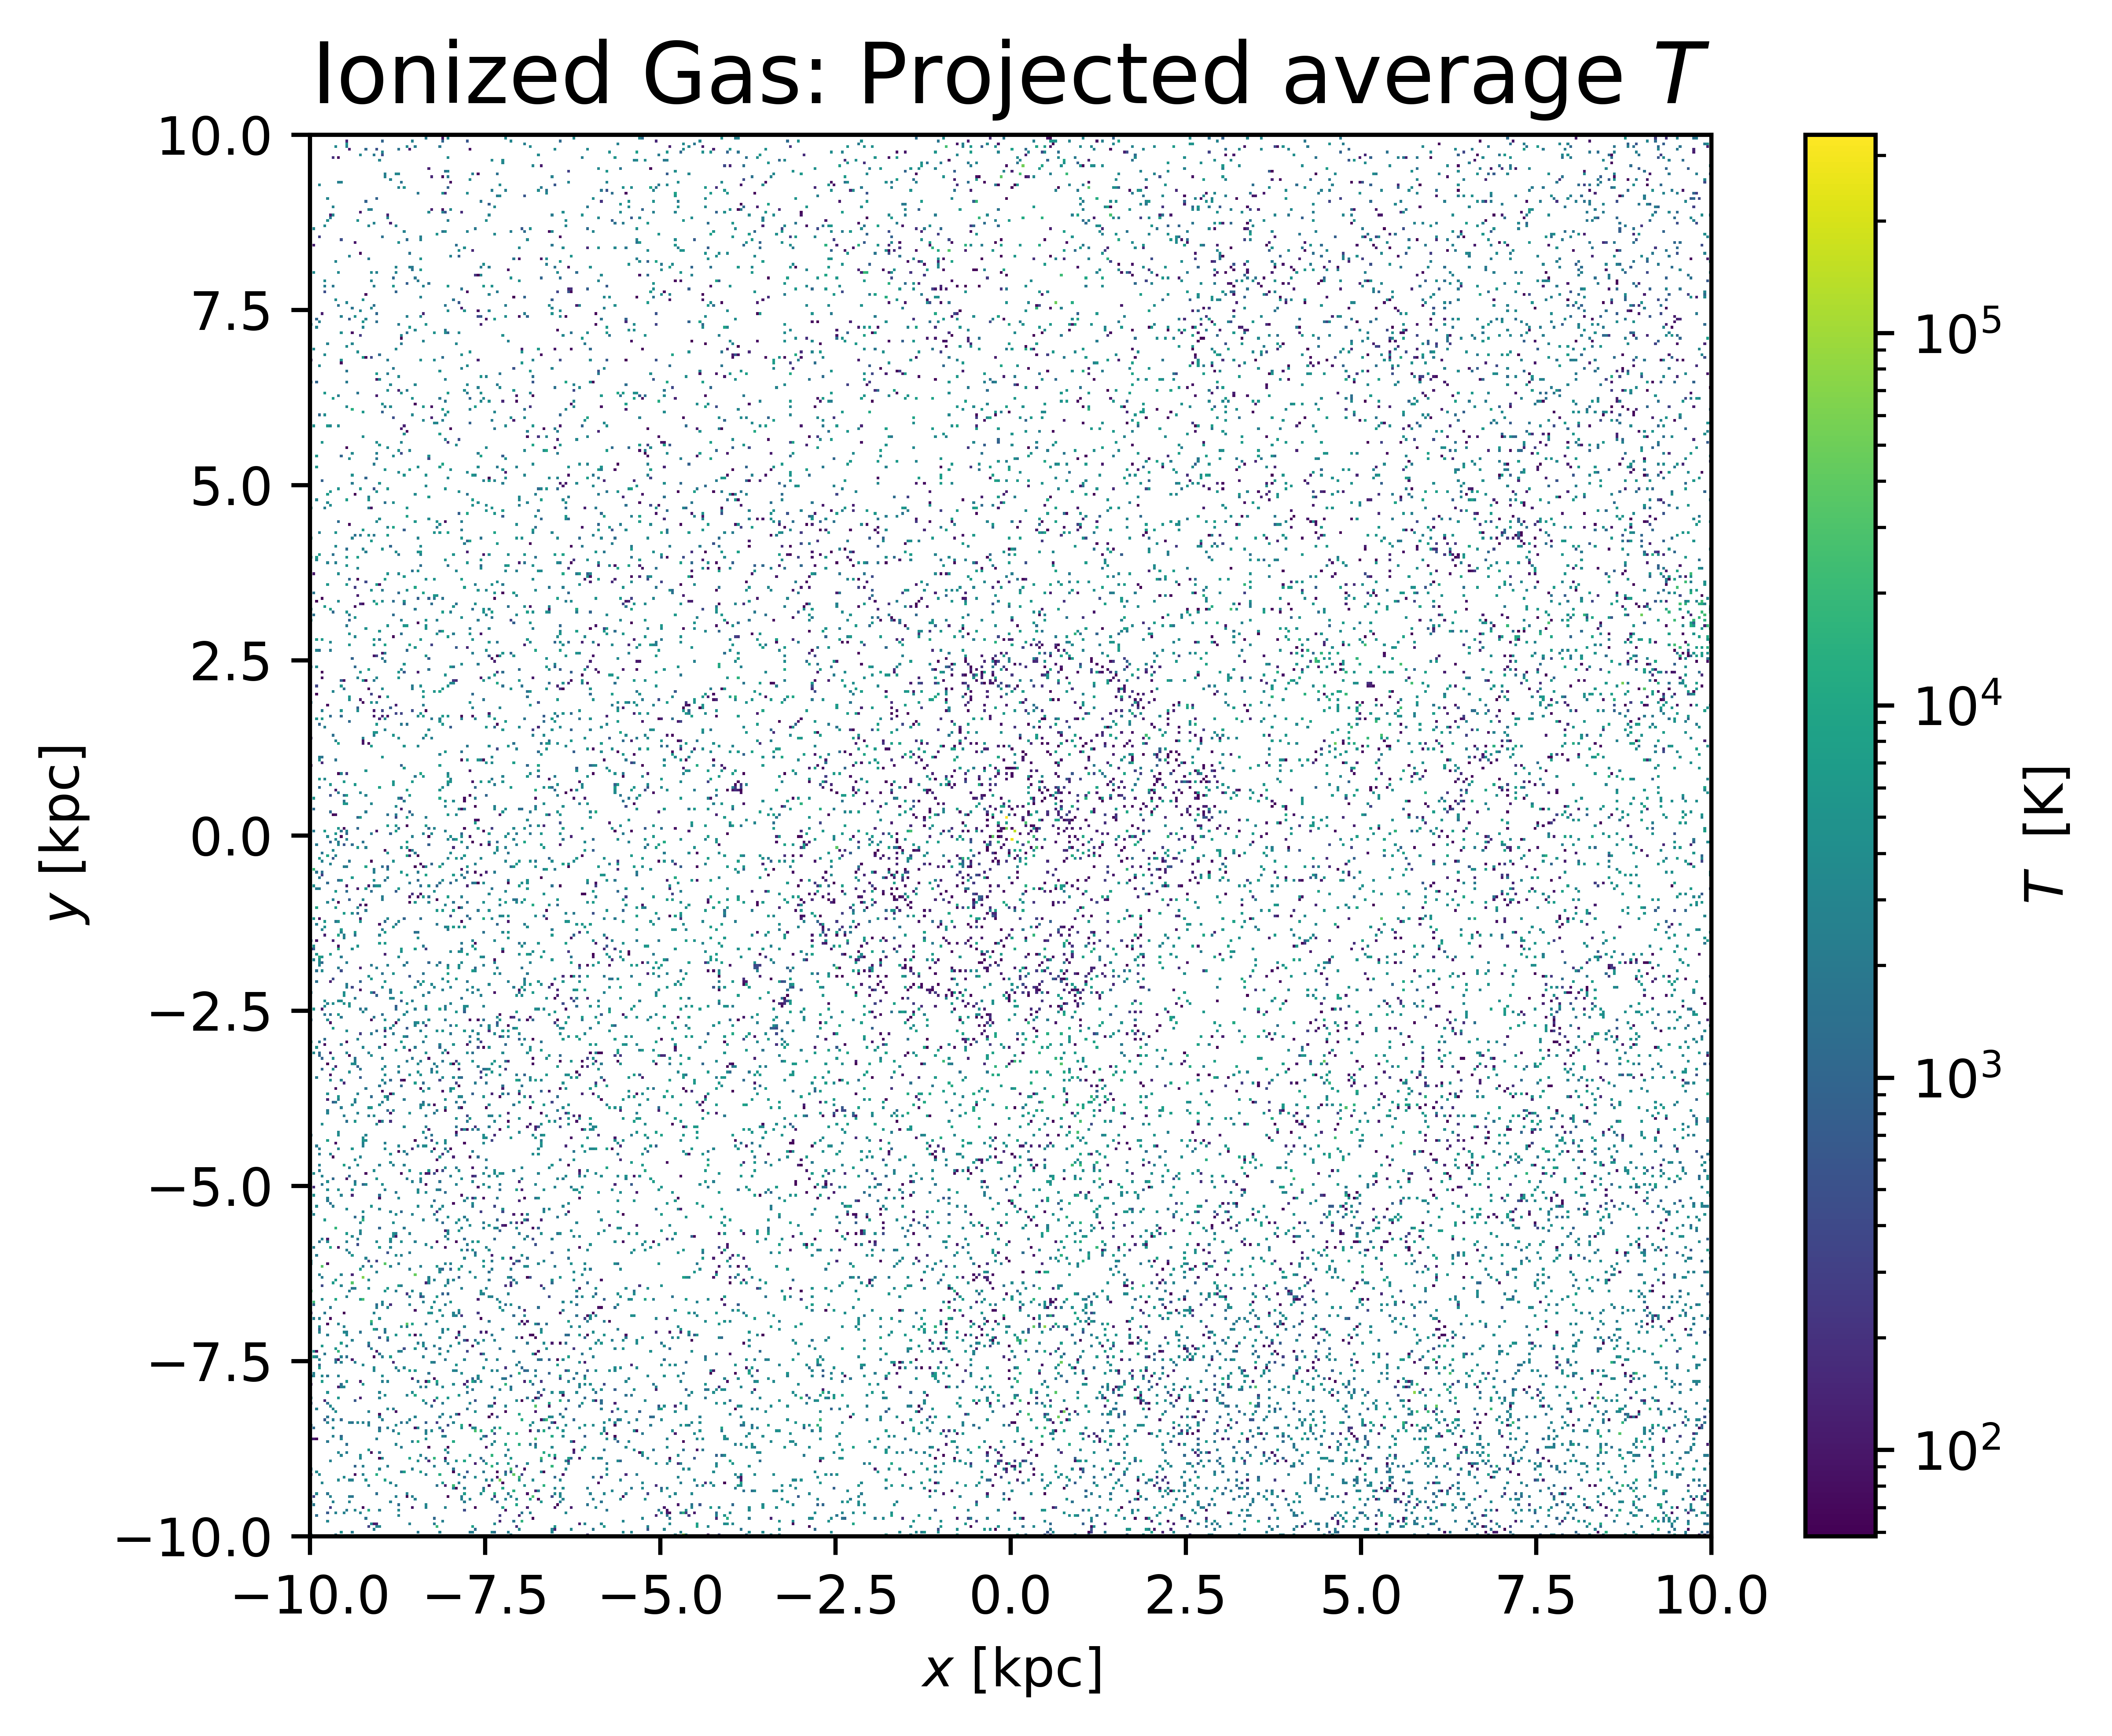

In [13]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = np.average(ioni_gas["temperatures"][:,:,mask], axis=2).value

plt.figure(dpi=1000)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$T$  [K]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(ioni_gas["name"]+": Projected average $T$", size=16)
plt.savefig("plots/cube - "+ioni_gas["name"]+" temp.png", bbox_inches='tight')
plt.show()

In [14]:
z_slice_min, z_slice_max = [-0.5,0.5]

In [15]:
mask = (voxel_centers_2[:,:,:,2] >= z_slice_min) & (voxel_centers_2[:,:,:,2] < z_slice_max)

NameError: name 'voxel_centers_2' is not defined

In [ ]:
ioni_gas["temperatures"][mask][np.isnan(ioni_gas["temperatures"][mask])] = 0
plt.hist(ioni_gas["temperatures"][mask])

In [ ]:
voxel_centers_2[mask][:,0]

In [ ]:
ioni_gas["temperatures"][mask]

In [ ]:
plt.scatter(voxel_centers_2[mask][:,0], voxel_centers_2[mask][:,1], c=ioni_gas["temperatures"][mask])

In [ ]:
slice_count

In [ ]:
np.shape((voxel_centers_2[:,:,:,2] >= z_slice_min) & (voxel_centers_2[:,:,:,2] < z_slice_max))

In [ ]:
z_slice_min, z_slice_max = [-0.02,0.02]
mask = (voxel_centers[2] >= z_slice_min) & (voxel_centers[2] < z_slice_max)
slice_count = ioni_gas["temperatures"][(voxel_centers_2[:,:,:,2] >= z_slice_min) & (voxel_centers_2[:,:,:,2] < z_slice_max)].value

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$T$  [K]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(dict["name"]+": $T$ at $z$ = 0 kpc", size=16)
plt.savefig("plots/cube - "+ioni_gas["name"]+" temp.png", bbox_inches='tight')
# plt.savefig("plots/cube - "+dict["name"]+" mass.svg", bbox_inches='tight')

plt.show()

In [ ]:
# generate set of ijk bin references 
voxel_centers_2 = np.transpose(np.meshgrid(bin_centers, bin_centers, bin_centers, indexing='ij')).swapaxes(0,2)
voxel_distances = np.sqrt(np.sum(voxel_centers_2**2, axis=3))
dark_mat["density"][np.where(voxel_distances < 4)]

radial_density = np.zeros(voxel_resolution)
r_array = np.linspace(0,cube_length/2, voxel_resolution)

i=0
for i in range(len(radial_density)-1):
    # average over the bins for which R_min < R < R_max
    radial_density[i] = np.average(dark_mat["density"][np.where((voxel_distances >= r_array[i]) & (voxel_distances <= r_array[i+1]))]).value
plt.plot(r_array+(r_array[1]-r_array[0])/2, radial_density, ".")

In [ ]:
2**9 / 2


In [ ]:
# filter by distance to Galaxy
max_distance_kpc = 10 * u.kpc
within_mw = part['dark'].prop('host.distance.total') < max_distance_kpc.value

# array of distances of each particle to the host Galaxy centre
dm = part['dark'].prop('host.distance.total')[within_mw]

num_bins = 2**9# 1200

# create bins array
distance_bins = np.linspace(0,max_distance_kpc.value,num_bins+1,endpoint=True) * u.kpc

# normalize bins
kpc_per_bin = max_distance_kpc / num_bins

# calculate spherical areas at each binned distance
avg_bin_distances = distance_bins[0:len(distance_bins)-1] + kpc_per_bin/2
avg_bin_areas = 4 * np.pi * avg_bin_distances**2

bin_volumes = 4/3*np.pi * (distance_bins[1:len(distance_bins)]**3 - distance_bins[0:len(distance_bins) - 1]**3)

# bin weighing by particle mass
# plt.figure(dpi=100)
# histogram_results = plt.hist(dm, bins=distance_bins.value, 
#                                  weights=part['dark']['mass'][within_mw], color="burlywood", alpha = 0.75)
# plt.xlabel("R [kpc]", size=20)
# plt.ylabel("Mass [M$_\odot$]", size=20)
# # plt.savefig("plots/m12i dm mass.png", bbox_inches='tight')
# # plt.savefig("plots/m12i dm mass.svg", bbox_inches='tight')
# plt.show()

histogram_results = np.histogram(dm, bins=distance_bins.value, 
                                 weights=part['dark']['mass'][within_mw])

binned_dm_density = histogram_results[0] * u.Msun / bin_volumes
binned_dm_density_si = binned_dm_density.to(u.kg/u.m**3)

In [ ]:
plt.figure(dpi=300, figsize=(6,3))
# plt.plot(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, color="green", linewidth=0.2, label="m12i")
plt.scatter(distance_bins[0:len(distance_bins) - 1].value, binned_dm_density_si.value, color="green", s=1.5, label="m12i")
plt.scatter(r_array, radial_density, marker=".", s=3, color="red")

plt.yscale('log')
plt.xlabel("R [kpc]", size=15)
plt.ylabel(r'$\rho_{DM}$'+"  [kg$\cdot$m$^{-3}$]", size = 15)

# plt.ylim([10**(-21),10**(-19)])
plt.xlim([0,5])
plt.legend(fontsize=9)

plt.show()

In [ ]:
# voxel_distances = np.sqrt(voxel_centers[0]**2 + voxel_centers[1]**2 + voxel_centers[2]**2)

# radial_density = np.zeros(voxel_resolution)
# # dr = cube_length/2 / voxel_resolution
# r_array = np.linspace(0,cube_length/2, voxel_resolution)

# i=0
# for i in range(len(radial_density)-1):
#     radial_density[i] = np.average(dark_mat["density"][(voxel_distances>=r_array[i]) & (voxel_distances<=r_array[i+1])]).value
# plt.plot(r_array, radial_density, ".")

In [ ]:
# OLD #################################################################
# bin all particles within cube, weighing by their mass
# dark_mat["mass_count"], voxel_coords = np.histogramdd(dark_mat["coords"][dark_mat["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=dark_mat["masses"])
# neut_gas["mass_count"], voxel_coords = np.histogramdd(neut_gas["coords"][neut_gas["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=neut_gas["masses"])
# ioni_gas["mass_count"], voxel_coords = np.histogramdd(ioni_gas["coords"][ioni_gas["within_cube"]], bins=(bins,bins,bins), 
#                                                       weights=ioni_gas["masses"])

In [ ]:
# obtain the bins indexes that each particle belongs to -- consider avoiding using scipy.stats.binned_statistic_dd
# values can take a list of data types that you want to bin
# dark_mat["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     dark_mat["bin_indexes"].append(np.digitize(dark_mat["coords"][dark_mat["within_cube"]][:, i], voxel_coords[i]))
# dark_mat["bin_indexes"] = np.concatenate(dark_mat["bin_indexes"]).reshape(np.shape(dark_mat["coords"][dark_mat["within_cube"]])) - 1

# neut_gas["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     neut_gas["bin_indexes"].append(np.digitize(neut_gas["coords"][neut_gas["within_cube"]][:, i], voxel_coords[i]))
# neut_gas["bin_indexes"] = np.concatenate(neut_gas["bin_indexes"]).reshape(np.shape(neut_gas["coords"][neut_gas["within_cube"]])) - 1

# ioni_gas["bin_indexes"] = []
# for i in range(len(voxel_coords)):
#     ioni_gas["bin_indexes"].append(np.digitize(ioni_gas["coords"][ioni_gas["within_cube"]][:, i], voxel_coords[i]))
# ioni_gas["bin_indexes"] = np.concatenate(ioni_gas["bin_indexes"]).reshape(np.shape(ioni_gas["coords"][ioni_gas["within_cube"]])) - 1


# # create arrays for storing velocity components
# dark_mat["v_x"], dark_mat["v_y"], dark_mat["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)
# neut_gas["v_x"], neut_gas["v_y"], neut_gas["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)
# ioni_gas["v_x"], ioni_gas["v_y"], ioni_gas["v_z"] = np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3), np.zeros([voxel_resolution]*3)

# # calculate the average velocity in each bin, in each direction
# def obtain_velocity_components(dict):
#     for i in product(range(voxel_resolution), repeat=3):
#         x, y, z = i[0], i[1], i[2]
    
#         selected_particles = np.where((dict["bin_indexes"][:,0] == x) & (dict["bin_indexes"][:,1] == y) & (dict["bin_indexes"][:,2] == z))
        
#         if not len(dict["masses"][selected_particles]) == 0:
#             dict["v_x"][x,y,z] = np.average(dict["v"][selected_particles][:,0], weights = dict["masses"][selected_particles])
#             dict["v_y"][x,y,z] = np.average(dict["v"][selected_particles][:,1], weights = dict["masses"][selected_particles])
#             dict["v_z"][x,y,z] = np.average(dict["v"][selected_particles][:,2], weights = dict["masses"][selected_particles])
#         else:
#             dict["v_x"][x,y,z], dict["v_y"][x,y,z], dict["v_z"][x,y,z] = np.nan, np.nan, np.nan

# obtain_velocity_components(dark_mat)
# obtain_velocity_components(neut_gas)
# obtain_velocity_components(ioni_gas)

In [ ]:
mass  = (np.average(part['dark'].prop('mass')) * u.solMass).to(u.kg)
m_aqn = 0.01 * u.kg

rho_dm = count * mass / voxel_volume.to(u.m**3) 
n_aqn = rho_dm / m_aqn

In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_coords[2] >= z_slice_min) & (voxel_coords[2] < z_slice_max)
slice_count = np.sum(rho_dm[:,:,mask], axis=2)

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho_{DM}$ [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(f"$rhodm$ in $z$-slice: [{z_slice_min},{z_slice_max}] kpc")
# plt.title()
plt.show()

In [ ]:
rho_dm2 = (count * u.solMass).to(u.kg) / voxel_volume.to(u.m**3)
print(np.sum(rho_dm2),np.sum(rho_dm))

In [ ]:
z_slice_min, z_slice_max = [-10,10]
mask = (voxel_coords[2] >= z_slice_min) & (voxel_coords[2] < z_slice_max)
slice_count = np.sum(rho_dm2[:,:,mask], axis=2)

plt.figure(dpi=400)
plt.imshow(slice_count, extent=[-10, 10, -10, 10], norm = matplotlib.colors.LogNorm())
plt.colorbar(label='$\\rho_{DM}$ [kg/m$^3$]')
plt.xlabel('$x$ [kpc]')
plt.ylabel('$y$ [kpc]')
plt.title(f"$rhodm$ in $z$-slice: [{z_slice_min},{z_slice_max}] kpc")
# plt.title()
plt.show()